In [665]:
from keras.models import Model
from keras.layers import (
    Activation,
    BatchNormalization,
    Dense,
    concatenate,
    GlobalAveragePooling1D,
    Input,
    Reshape,
)
import yaml
import keras
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
import torch
from pyts.datasets import load_basic_motions
import numpy as np
import pandas as pd
from keras import *
from keras.layers import *
import seaborn as sns
from sklearn.preprocessing import normalize,MinMaxScaler,Binarizer
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from keras.layers.convolutional import Conv1D, Conv2D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix,recall_score, classification_report, auc, roc_curve,matthews_corrcoef,accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.integrate import simps

In [3]:
path=r'data'

In [4]:
def transform_labels(y_train, y_test):
    """
    Transform label to min equal zero and continuous
    For example if we have [1,3,4] ---> [0,1,2]


    Parameters
    ----------
    y_train: array
        Labels of the train set

    y_test: array
        Labels of the test set


    Returns
    -------
    new_y_train: array
        Transformed y_train array

    new_y_test: array
        Transformed y_test array
    """

    # Initiate the encoder
    encoder = LabelEncoder()

    # Concatenate train and test to fit
    y_train_test = np.concatenate((y_train, y_test), axis=0)

    # Fit the encoder
    encoder.fit(y_train_test.ravel())

    # Transform to min zero and continuous labels
    new_y_train_test = encoder.transform(y_train_test.ravel())

    # Resplit the train and test
    new_y_train = new_y_train_test[0 : len(y_train)]
    new_y_test = new_y_train_test[len(y_train) :]

    return new_y_train, new_y_test

In [5]:
X_train = np.load(path + "/X_train.npy")
y_train = np.load(path + "/y_train.npy")
X_test = np.load(path + "/X_test.npy")
y_test = np.load(path + "/y_test.npy")
X = np.load(path + "/X.npy")
y = np.load(path + "/y.npy")
y_train, y_test  = transform_labels(y_train, y_test)
y_train_nonencoded, y_test_nonencoded , y_nonencoded = y_train, y_test, y

# One hot encoding of the labels
enc = OneHotEncoder()
enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
y = enc.transform(y.reshape(-1, 1)).toarray()
X_train = np.reshape(
    np.array(X_train),
    (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1),
    order="C",
)
X_test = np.reshape(
    np.array(X_test),
    (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1),
    order="C",
)
X = np.reshape(
    np.array(X),
    (X.shape[0], X.shape[1], X.shape[2], 1),
    order="C",
)

In [6]:
input_shape=X_train.shape[1:]

In [7]:
def grad_cam(data, model, layer_name, conv_type):
    """
    Grad-CAM output

    Parameters
    ----------
    data: array
        MTS sample

    model: model
        Trained model

    layer_name: string
        Name of the convolution layer

    conv_type: string
        Type of the convolution layer

    Returns
    -------
    heatmap: array
        Heatmap
    """

    # Get class-specific gradient information with respect to feature map activations of the convolution layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        pred_class = preds[:, pred_index]

    grads = tape.gradient(pred_class, conv_layer_output) #这是输出神经元(预测概率最高的或者选定的那个)对最后一个卷积层输出特征图的梯度

    # Compute a weighted combination between the feature maps
    if conv_type == "1D":
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
        conv_layer_output = conv_layer_output[0]
        heatmap = conv_layer_output * pooled_grads
        heatmap = tf.reduce_mean(heatmap, axis=1)
        heatmap = np.array(heatmap).reshape(1, heatmap.shape[0], 1, 1)
        heatmap = tf.image.resize(heatmap, size=(1, data.shape[2]))
        heatmap = np.squeeze(heatmap)
    else:
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_layer_output = conv_layer_output[0]
        heatmap = conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # relu函数

    return heatmap.numpy()

In [8]:
def grad_cam(data, model, layer_name, conv_type):
    """
    Grad-CAM output


    Parameters
    ----------
    data: array
        MTS sample

    model: model
        Trained model

    layer_name: string
        Name of the convolution layer

    conv_type: string
        Type of the convolution layer


    Returns
    -------
    heatmap: array
        Heatmap
    """

    # Get class-specific gradient information with respect to feature map activations of the convolution layer
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    # tf.GradientTape 与 tf.gradient()  相比增加了上下文属性，仅对 with tf.GradientTape() as tape 范围以内的变量计算梯度，更方便进行梯度计算管理。 
    with tf.GradientTape() as tape:
        conv_layer_output, preds = grad_model(data)
        # print(conv_layer_output, preds)
        # if pred_index is None:
        pred_index = tf.argmax(preds[0])
        pred_class = preds[:, pred_index]

    grads = tape.gradient(pred_class, conv_layer_output) #这是输出神经元(预测概率最高的或者选定的那个)对最后一个卷积层输出特征图的梯度

    # Compute a weighted combination between the feature maps
    if conv_type == "1D":
        # print(111)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
        conv_layer_output = conv_layer_output[0]
        heatmap = conv_layer_output * pooled_grads
        heatmap = tf.reduce_mean(heatmap, axis=(1))
        heatmap = np.array(heatmap).reshape(1, heatmap.shape[0], 1, 1)
        heatmap = keras.layers.UpSampling2D(size=(1, data.shape[2]))(heatmap)
        heatmap = np.squeeze(heatmap)
    else:
        # print(222)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_layer_output = conv_layer_output[0]
        # print(conv_layer_output)
        # print(pooled_grads.shape)
        # heatmap = conv_layer_output * pooled_grads
        # heatmap = tf.reduce_mean(heatmap, axis=(2))
        heatmap = conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

    # Keep positive values
    # heatmap = np.maximum(heatmap, 0) #relu函数
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) #relu函数
    
    # print(heatmap)
    # return heatmap
    return heatmap.numpy()


def get_heatmap(
    configuration, xp_dir, model, X_train, X_test, y_train_nonencoded, y_test_nonencoded
):
    """
    Get the heatmap supporting a prediction


    Parameters
    ----------
    configuration: array
        Elements from the configuration file

    xp_dir: string
        Directory used to save the results of the experiment

    model: model
        Trained model

    X_train: array
        Train set without labels

    X_test: array
        Test set without labels

    y_train_nonencoded: array
        Labels of the train set non-encoded

    y_test_nonencoded: array
        Labels of the test set non-encoded
    """

    # Retrieve configuration
    # print(333)
    set_explanation = configuration["set"]
    mts_sample_id = configuration["mts_sample_id"]
    layer_name = configuration["layer_name"]

    # Get MTS sample
    set_dict = {
        "train": [X_train, y_train_nonencoded],
        "test": [X_test, y_test_nonencoded],
    }
    mts_label = set_dict[set_explanation][1][mts_sample_id]
    mts_sample = set_dict[set_explanation][0][mts_sample_id]
    mts_sample = np.expand_dims(mts_sample, 0)

    # Get Grad-CAM output
    heatmap = grad_cam(mts_sample, model, layer_name, layer_name[:2])

    # Save and display the heatmap
    plt.figure(figsize=(25, 10))
    # MinMaxScaler
    heatmap = np.swapaxes(normalize(heatmap,norm='l2'), 0, 1)
    # print(heatmap.shape)
    # print(heatmap)
    xticklabels = range(1, mts_sample.shape[1] + 1)
    yticklabels = range(1, mts_sample.shape[2] + 1)
    sns.heatmap(
        heatmap, xticklabels=xticklabels, yticklabels=yticklabels, cmap="RdBu_r"
    )
    plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Layer

class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, **kwargs):
        super(CrossAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)

    def call(self, inputs):
        Q, K, V = inputs
        batch_size = tf.shape(Q)[0]
        seq_len_Q = tf.shape(Q)[1]
        seq_len_K = tf.shape(K)[1]
        
        # 计算 Q, K, V
        Q = self.query_dense(Q)
        K = self.key_dense(K)
        V = self.value_dense(V)
        
        # 分成多个头
        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)
        
        # 计算注意力分数
        scores = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(tf.cast(self.embed_dim // self.num_heads, tf.float32))
        
        # 计算注意力权重
        attention_weights = tf.nn.softmax(scores, axis=-1)
        
        # 计算注意力输出
        context = tf.matmul(attention_weights, V)
        context = self.combine_heads(context, batch_size)
        
        return context
    
    def split_heads(self, x, batch_size):
        depth = self.embed_dim // self.num_heads
        x = tf.reshape(x, (batch_size, -1, self.num_heads, depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def combine_heads(self, x, batch_size):
        depth = self.embed_dim // self.num_heads
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        x = tf.reshape(x, (batch_size, -1, self.embed_dim))
        return x


def stcan_model1(input_shape, n_class, embed_dim=512, num_heads=1):
    n = input_shape[0]
    print(n,1111)
    k = input_shape[1]
    print(k,1112)
    input_layer = Input(shape=(n, k, 1))

    # 2D convolution layers
    a = Conv2D(
        filters=64,
        kernel_size=(n, 1),
        strides=(1, 1),
        padding="same",
        input_shape=(n, k, 1),
        name="2D",
    )(input_layer)
    a = BatchNormalization()(a)
    a = Activation("relu", name="2D_Activation")(a)
    a = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1))(a)
    a = Activation("relu", name="2D_Reduced_Activation")(a) 
    x = Reshape((n, k))(a)

    # 1D convolution layers
    b = Reshape((n, k))(input_layer)
    b = LSTM(100, return_sequences=True)(b)
    b = LSTM(1, return_sequences=True)(b)
    b = BatchNormalization()(b)
    y = Activation("relu", name="1D_Activation")(b)


    # Cross-Attention
    z = CrossAttention(embed_dim, num_heads)([y,x,x])
    z = GlobalAveragePooling1D()(z)
    output_layer = Dense(n_class, activation="softmax")(z)

    model = Model(input_layer, output_layer)
    focal_loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0)
    model.compile(loss=focal_loss, metrics=["AUC"], optimizer='sgd')
    return model

In [393]:
def stcan_model2(input_shape, n_class, embed_dim=512, num_heads=1):
    n = input_shape[0]
    # print(n,1111)
    k = input_shape[1]
    # print(k,1112)
    input_layer = Input(shape=(n, k, 1))

    # 2D convolution layers
    a = Conv2D(
        filters=64,
        kernel_size=(n, 1),
        strides=(1, 1),
        padding="same",
        input_shape=(n, k, 1),
        name="2D",
    )(input_layer)
    a = BatchNormalization()(a)
    a = Activation("relu", name="2D_Activation")(a)
    a = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1))(a)
    a = Activation("relu", name="2D_Reduced_Activation")(a) 
    x = Reshape((n, k))(a)

    # 1D convolution layers
    b = Reshape((n, k))(input_layer)
    b = LSTM(100, return_sequences=True)(b)
    b = LSTM(1, return_sequences=True)(b)
    b = BatchNormalization()(b)
    y = Activation("relu", name="1D_Activation")(b)


    # Cross-Attention
    # z = CrossAttention(embed_dim, num_heads)([y,x,x])
    # Cross-Attention
    z = CrossAttention(embed_dim, num_heads)([x,y,y])
    # print(z.shape,1111)
    # Reshape z to fit Conv2D
    # z = Reshape((z.shape[1], z.shape[2], 1))(z)
    
    # Add Conv2D classifier
    z_reshaped = Reshape((n, 1, embed_dim))(z)
    
    # Conv2D layers for classification
    z_conv = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(z_reshaped)
    z_conv = Flatten()(z_conv)
    output_layer = Dense(n_class, activation='softmax')(z_conv)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    focal_loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.5, gamma=4.0)
    model.compile(loss=focal_loss, metrics=["AUC"], optimizer='sgd')
    return model




In [407]:
model = stcan_model2(input_shape, n_class=2,embed_dim=55,num_heads=5)

In [408]:
path1= r'best_model/b1/'
path2=str(4)+'/'+str('stcan_best_weights.hdf5')
best_weights_filepath = path1+path2
print(best_weights_filepath)
model.load_weights(best_weights_filepath)

best_model/b1/4/stcan_best_weights.hdf5


In [409]:
col=['N1_1','VRTG','ALT_RADIO','DIST_TO_THR_CONV','IVV','LOC','PITCH']
df=pd.read_csv('data_7_55_max.csv')
df=df[col]
# data1=df['N1_1'].iloc[:88000]
data1=df['N1_1']
data=data1.values.reshape(-1,55)
data=pd.DataFrame(data)

In [410]:
data

0     1     2     3     4     5     6     7     8     9   ...    45  \
0     58.4  58.4  57.4  56.5  56.9  57.0  55.3  55.3  55.3  55.5  ...  57.5   
1     54.9  54.9  54.8  54.9  55.1  55.1  56.4  54.3  53.3  53.4  ...  47.0   
2     57.3  56.6  55.8  56.3  56.1  56.1  56.1  56.1  56.0  56.0  ...  60.8   
3     57.1  56.5  49.9  41.1  50.4  56.6  58.1  59.8  59.9  59.8  ...  56.6   
4     62.6  62.6  63.3  68.0  68.8  68.4  68.5  68.5  68.5  68.5  ...  46.4   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1965  55.4  55.4  55.4  55.4  55.6  55.8  55.1  55.1  55.1  55.0  ...  56.6   
1966  54.8  55.3  55.3  56.6  58.1  58.1  59.3  59.4  59.4  56.6  ...  53.0   
1967  59.8  58.6  58.8  58.8  58.8  58.6  58.6  58.6  58.6  58.6  ...  53.8   
1968  59.4  59.4  59.6  61.1  61.1  61.0  61.1  61.1  61.1  61.1  ...  43.9   
1969  50.4  50.1  50.4  50.3  50.3  50.3  50.3  50.3  50.3  50.3  ...  43.5   

        46    47    48    49    50    51    52    53    54  
0     54.4  49.0  49.1  49.9  45.9  38.6  44.3  62.3  81.1  
1     40.1  34.6  31.5  30.9  31.1  34.9  43.9  63.0  81.3  
2     55.5  46.8  38.8  33.9  31.4  32.3  36.5  49.4  67.6  
3     51.9  43.5  36.4  32.5  31.3  31.4  31.4  31.4  32.4  
4     39.1  34.0  31.6  31.3  32.4  37.0  50.8  70.0  83.6  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
1965  55.5  49.5  41.0  35.3  32.1  32.1  34.9  41.9  59.5  
1966  45.6  38.3  33.4  31.4  31.5  31.8  35.1  42.4  51.0  
1967  45.9  38.5  34.0  32.3  32.1  34.6  42.0  60.6  76.4  
1968  37.0  33.1  32.1  32.1  32.4  33.6  39.6  56.5  73.8  
1969  37.0  33.1  31.9  31.9  32.0  32.0  32.1  31.8  30.8  

[1970 rows x 55 columns]

In [411]:
model.summary()

Model: "model_58007"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 7, 55, 1)]   0           []                               
                                                                                                  
 2D (Conv2D)                    (None, 7, 55, 64)    512         ['input_18[0][0]']               
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 55, 64)   256         ['2D[0][0]']                     
 ormalization)                                                                                    
                                                                                                  
 reshape_51 (Reshape)           (None, 7, 55)        0           ['input_18[0][0]']     

In [412]:
set_explanation = 'ALL'
set_dict = {
    "train": [X_train, y_train_nonencoded],
    "test": [X_test, y_test_nonencoded],
    'ALL':[X, y_nonencoded],
}
layer_name="2D_Activation"

In [413]:
# 初始化列表
heatmaps = {i: [] for i in range(7)}

# 遍历样本
for i in range(1970):
    mts_sample_id = i
    mts_label = set_dict[set_explanation][1][mts_sample_id]
    mts_sample = set_dict[set_explanation][0][mts_sample_id]
    mts_sample = np.expand_dims(mts_sample, 0)
    
    # 预测
    y_pred = np.argmax(model.predict(mts_sample), axis=1)
    
    # if y_pred == 1:
    heatmap = grad_cam(mts_sample, model, layer_name, layer_name[:2])
    # if y_pred == 1:
    # 将 heatmap 的各个部分存入对应的列表
    for j in range(7):
        heatmaps[j].append(heatmap[j])


1/1 [==============================] - 0s 21ms/step


In [666]:
# 初始化p1数组
TIC = np.empty([55, 7])

# 逐行计算均值并赋值给p1
for j in range(7):
    TIC[:, j] = np.mean(np.array(heatmaps[j]), axis=0)

In [668]:
TIC

array([[0.08876006, 0.15792826, 0.13872591, 0.41030148, 0.06117599,
        0.24498686, 0.23307143],
       [0.08218786, 0.15286602, 0.1385826 , 0.4010199 , 0.0549512 ,
        0.24548714, 0.2224651 ],
       [0.07588817, 0.14877649, 0.13939625, 0.3927227 , 0.04913189,
        0.24607454, 0.21236147],
       [0.0694875 , 0.14571995, 0.14141443, 0.38471505, 0.04342777,
        0.2465616 , 0.20194721],
       [0.06320503, 0.14360236, 0.14435658, 0.37737307, 0.03807957,
        0.24698442, 0.19169873],
       [0.05681201, 0.14293678, 0.14833908, 0.37025717, 0.03286576,
        0.24762599, 0.18121634],
       [0.05056227, 0.14405236, 0.15304153, 0.36375535, 0.02853399,
        0.24838468, 0.1710175 ],
       [0.044183  , 0.14675184, 0.1585945 , 0.35734189, 0.02506457,
        0.24923575, 0.16042504],
       [0.03807859, 0.15102731, 0.16456102, 0.35125726, 0.02277813,
        0.25034913, 0.14993688],
       [0.03243556, 0.15722902, 0.17120744, 0.34534475, 0.02199503,
        0.25185224, 0.1

In [670]:
plt.figure(figsize=(25, 10))
# MinMaxScaler
# heatmap = np.swapaxes(normalize(p1,norm='l2'), 0, 1)
yticklabels = ['N1_1','VRTG','ALT_RADIO','DIST','IVV','LOC','PITCH']
xticklabels = range(1, mts_sample.shape[2] + 1)
# yticklabels = range(1, mts_sample.shape[2] + 1)
# set_yticks([y_to_num[v] for v in y_labels])
# ax.set_y
#  ticklabels(y_labels)
sns.heatmap(
    TIC.T, xticklabels=xticklabels, yticklabels=yticklabels, cmap='RdYlBu_r'
)
font2 = {'weight': 'normal', 'size': 15}
plt.xlabel('Landing Time/second', fontdict=font2)
plt.ylabel('Flight critical parameter.', fontdict=font2)
plt.subplots_adjust(right=0.8)
plt.savefig('TIA.pdf', format='pdf',dpi=1000)
plt.show()

In [419]:
ZZZ

NameError: name 'ZZZ' is not defined

In [554]:
def PCM(data):
    # data11=data.iloc[num,:]
    # data12=pd.DataFrame(data11.values.reshape(55,1))
    Q3=np.percentile(data, 75, axis=0)
    Q1=np.percentile(data, 25, axis=0)
    IQR = Q3 - Q1
    LF = Q1 - 1.5 * IQR
    UF = Q3 + 1.5 * IQR

    max_F = np.max(data, axis=0)
    min_F = np.min(data, axis=0)
    N = np.maximum(max_F - UF, LF - min_F)
    N = np.maximum(N, 0)
    G_array = np.ones(data.shape)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data.iloc[i, j] > UF[j] or data.iloc[i, j] < LF[j]:
                S = np.maximum(data.iloc[i, j] - UF[j],LF[j] - data.iloc[i, j])
                Q = S/N[j]
                G_array[i,j] = 1-Q
            else:
                G_array[i,j] = 1
    return G_array

In [556]:
# 读取数据
col = ['N1_1', 'VRTG', 'ALT_RADIO', 'DIST_TO_THR_CONV', 'IVV', 'LOC', 'PITCH']
df = pd.read_csv('data/data_7_55_max.csv')
df = df[col]

In [558]:
results = []
for i in col:
    data1 = df[i].values
    data = data1.reshape(-1, 55)
    data = pd.DataFrame(data)
    G= PCM(data)
    results.append(G)

In [636]:
results_array = np.array(results)
fligit_sigle = results_array[:, 519, :]
fligit_sigle

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1. 

In [792]:
flight_scores = []
flight_scores_1 = []
A = np.ones((7, 55))*TIC.T
all_sum = np.sum(A)
B = TIC.T
all_sum_B = np.sum(B)
for i in range(len(results_array[0])):
    fligit_sigle = results_array[:, i, :]
    F = fligit_sigle*TIC.T
    F_sum = np.sum(F)
    flight_scores.append(F_sum*100/all_sum)
    flight_scores_1.append(F_sum*100/all_sum_B)

In [789]:
flight_scores

[99.497291831773,
 86.1408603991919,
 98.64130501600292,
 99.57014275512674,
 83.63510269294625,
 99.15353283928454,
 85.58102421454363,
 100.0,
 83.59678247417953,
 100.0,
 82.20667164661798,
 100.0,
 98.4185559872012,
 99.87965017649232,
 83.06959219996207,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 98.06582482649067,
 81.77526179571586,
 99.98944510302944,
 99.90621476350562,
 99.99999623694455,
 99.88056450667274,
 100.0,
 100.0,
 99.99668570507066,
 100.0,
 99.18545906669637,
 99.9780722472007,
 99.92910787398685,
 99.31571744916488,
 99.26021906514316,
 99.32147274609352,
 100.0,
 99.96757007323909,
 99.98538688291738,
 100.0,
 98.323444663726,
 99.42671736316858,
 100.0,
 100.0,
 100.0,
 99.82819681664597,
 100.0,
 99.10535024163119,
 100.0,
 75.57306907418025,
 100.0,
 99.9265477251607,
 98.92857798363048,
 90.95015474292627,
 99.86664109155134,
 99.58348344811046,
 99.99205202798323,
 99.65817163515814,
 100.0,
 99.66612121499016,
 99.40855416557807,
 99.86664825247729,
 99.7273

In [793]:
flight_scores_1

[99.497291831773,
 86.1408603991919,
 98.64130501600292,
 99.57014275512674,
 83.63510269294625,
 99.15353283928454,
 85.58102421454363,
 100.0,
 83.59678247417953,
 100.0,
 82.20667164661798,
 100.0,
 98.4185559872012,
 99.87965017649232,
 83.06959219996207,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 98.06582482649067,
 81.77526179571586,
 99.98944510302944,
 99.90621476350562,
 99.99999623694455,
 99.88056450667274,
 100.0,
 100.0,
 99.99668570507066,
 100.0,
 99.18545906669637,
 99.9780722472007,
 99.92910787398685,
 99.31571744916488,
 99.26021906514316,
 99.32147274609352,
 100.0,
 99.96757007323909,
 99.98538688291738,
 100.0,
 98.323444663726,
 99.42671736316858,
 100.0,
 100.0,
 100.0,
 99.82819681664597,
 100.0,
 99.10535024163119,
 100.0,
 75.57306907418025,
 100.0,
 99.9265477251607,
 98.92857798363048,
 90.95015474292627,
 99.86664109155134,
 99.58348344811046,
 99.99205202798323,
 99.65817163515814,
 100.0,
 99.66612121499016,
 99.40855416557807,
 99.86664825247729,
 99.7273

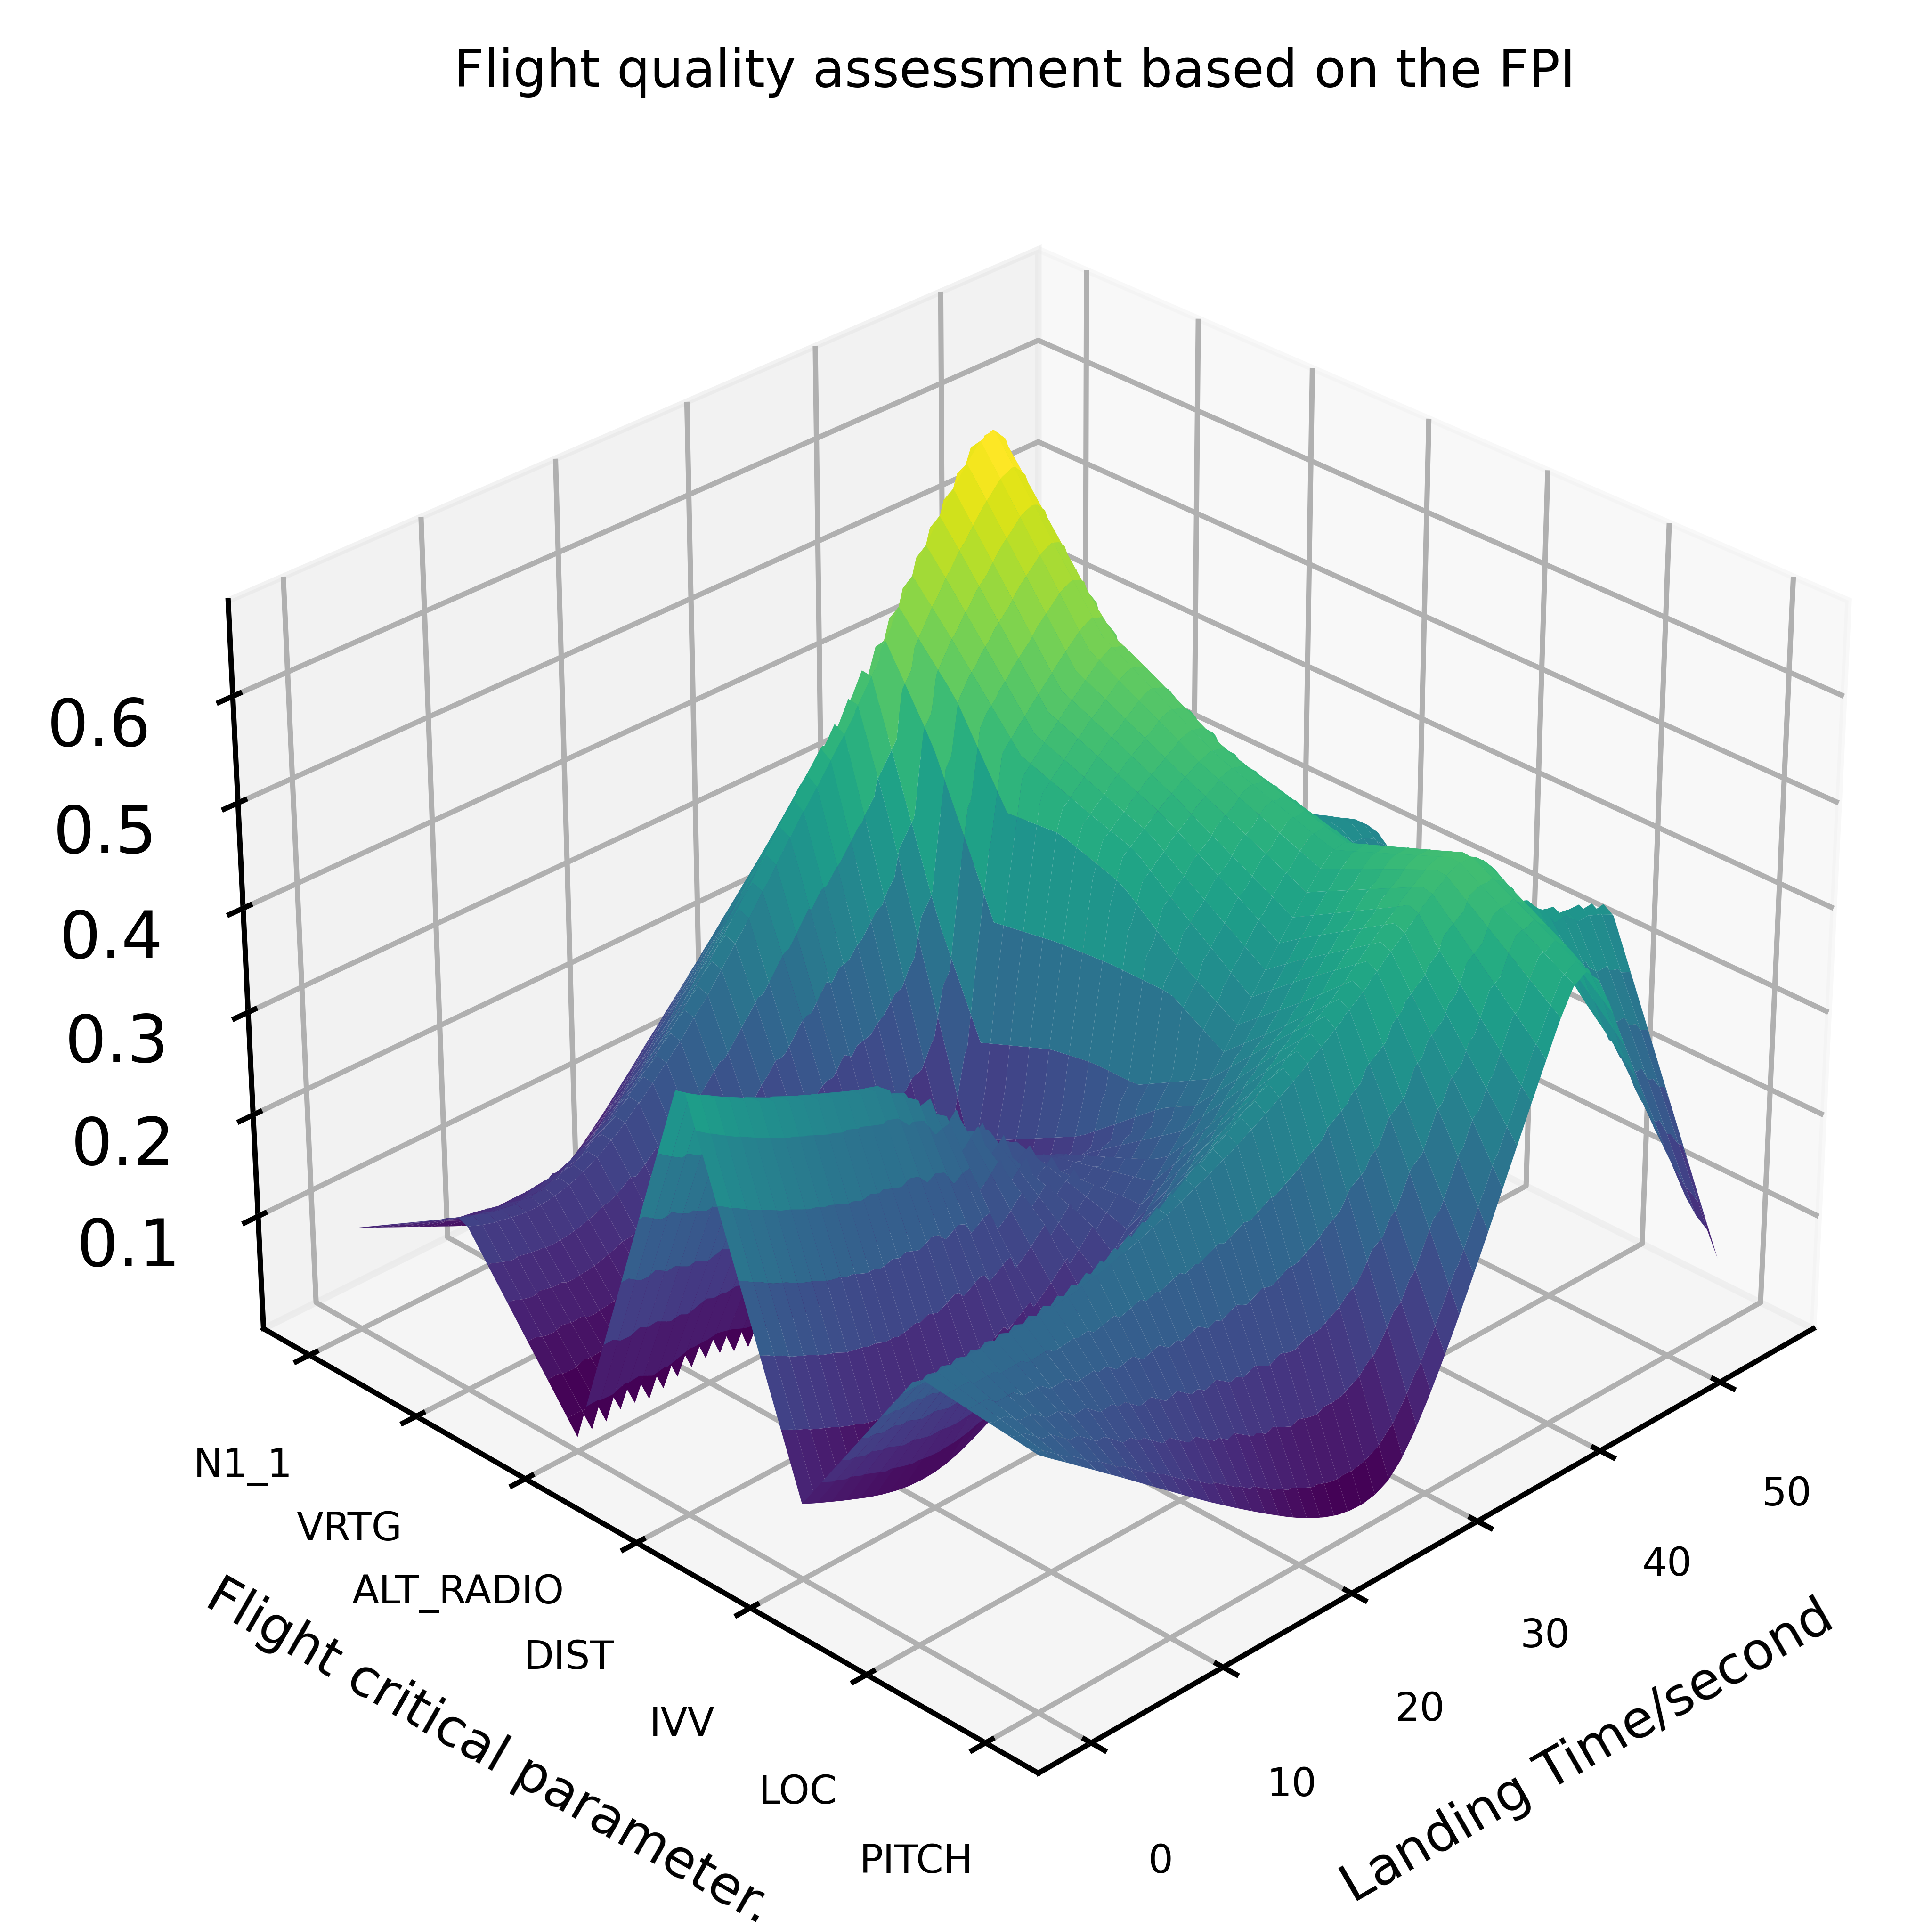

In [661]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.integrate import simps

# 读取数据
sigle = results_array[:, 53, :]*TIC.T
data = pd.DataFrame(sigle)

# 获取数据的形状
rows, cols = data.shape

# 将数据转换为NumPy数组
data_array = data.values

# 创建网格
x = np.arange(cols)
y = np.arange(rows)
x, y = np.meshgrid(x, y)

# 插值到更细的网格上以使表面更加平滑
xi = np.linspace(0, cols-1, cols*10)
yi = np.linspace(0, rows-1, rows*10)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x.flatten(), y.flatten()), data_array.flatten(), (xi, yi), method='linear')

# 创建三维图形
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三维图形

ax.plot_surface(xi, yi, zi,cmap='viridis')

# 设置视角
ax.view_init(elev=30, azim=45)  # elev 是高度角度, azim 是方位角度

# 添加标题和轴标签
ax.set_title('Flight quality assessment based on the FPI',fontsize=8)
ax.set_xlabel('Landing Time/second',fontsize=8)
ax.set_ylabel('Flight critical parameter.',fontsize=8)
ax.set_zlabel('Values')


yticklabels = ['N1_1','VRTG','ALT_RADIO','DIST','IVV','LOC','PITCH']
ax.set_yticks(np.arange(len(yticklabels)))  # 设置 y 轴刻度位置
ax.set_yticklabels(yticklabels, fontsize=6)
# 调整刻度标签的字体大小
ax.tick_params(axis='x', labelsize=6)
ax.set_xlim(ax.get_xlim()[::-1])



# 显示图形
plt.show()


In [781]:
def fpi(index,save=False):
    # 读取数据
    sigle = results_array[:, index, :]*TIC.T
    data = pd.DataFrame(sigle)

    # 获取数据的形状
    rows, cols = data.shape

    # 将数据转换为NumPy数组
    data_array = data.values

    # 创建网格
    x = np.arange(cols)
    y = np.arange(rows)
    x, y = np.meshgrid(x, y)

    # 插值到更细的网格上以使表面更加平滑
    xi = np.linspace(0, cols-1, cols*10)
    yi = np.linspace(0, rows-1, rows*10)
    xi, yi = np.meshgrid(xi, yi)

    zi = griddata((x.flatten(), y.flatten()), data_array.flatten(), (xi, yi), method='linear')

    # 创建三维图形
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 绘制三维图形

    ax.plot_surface(xi, yi, zi,cmap='viridis')

    # 设置视角
    ax.view_init(elev=30, azim=45)  # elev 是高度角度, azim 是方位角度

    # 添加标题和轴标签
    ax.set_title('Flight quality assessment based on the FPI',fontsize=15)
    ax.text2D(0.5, 0.95, f'Flight score: {flight_scores[index]:.2f}', fontsize=12, ha='center', transform=ax.transAxes)
    ax.set_xlabel('Landing Time/second',fontsize=8)
    ax.set_ylabel('Flight critical parameter',fontsize=8)
    ax.set_zlabel('Values')


    yticklabels = ['N1_1','VRTG','ALT_RADIO','DIST','IVV','LOC','PITCH']
    ax.set_yticks(np.arange(len(yticklabels)))  # 设置 y 轴刻度位置
    ax.set_yticklabels(yticklabels, fontsize=6)
    # 调整刻度标签的字体大小
    ax.tick_params(axis='x', labelsize=6)
    ax.set_xlim(ax.get_xlim()[::-1])
    if save:
        filename = f'save/fpi_{index}.pdf'
        plt.savefig(filename, format='pdf', bbox_inches='tight',dpi = 3000)


    # 显示图形
    plt.show()


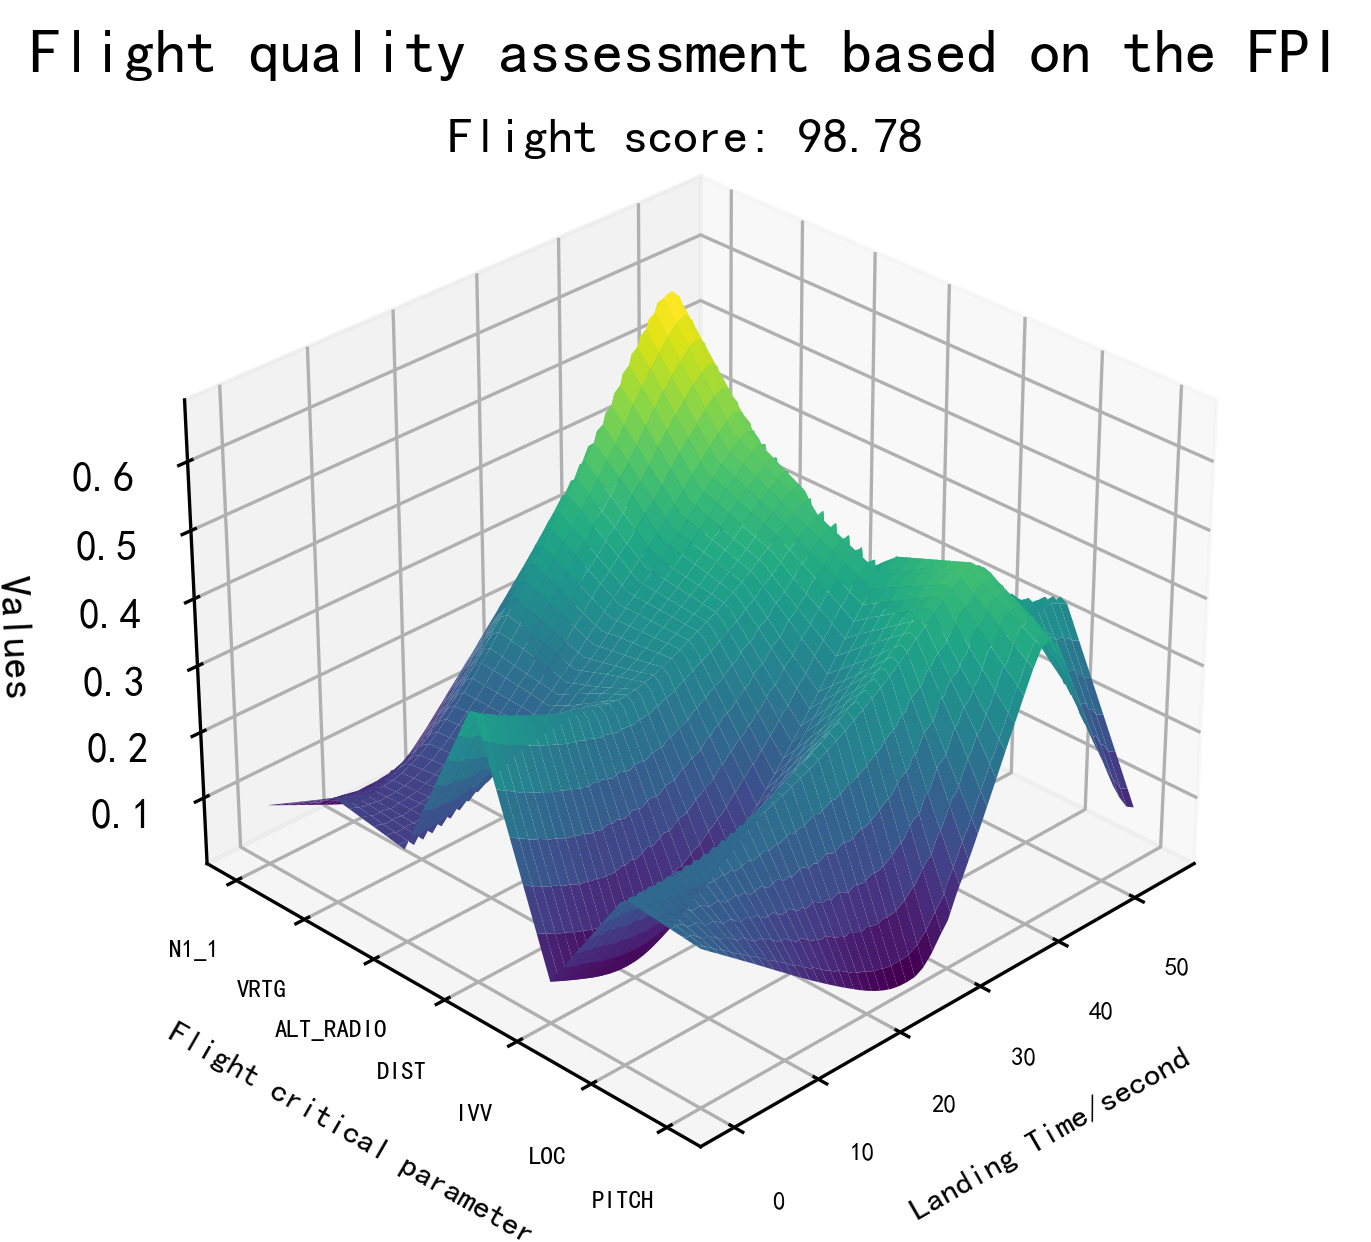

In [801]:
fpi(653,save=1)

In [694]:
yname = ['N1_1','VRTG','ALT_RADIO','DIST_TO_THR_CONV','IVV','LOC','PITCH']
ylabel = [' Rotor speed of engine/ %RPM','Vertical acceleration/ G','Radio altitude/FEET','Distance to runway threshold / m','Instantaneous vertical velocity/ FT/MIN','Localizer deviation/DDM','Aircraft pitch angle/DEG']

In [794]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def iqr_pic(index, name, labelname, save=False):
    data1 = df[name]
    data = data1.values.reshape(-1, 55)
    data = pd.DataFrame(data)
    data11 = data.iloc[index, :]
    data12 = pd.DataFrame(data11.values.reshape(55, 1))

    # 计算统计量
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    Q2 = data.quantile(0.5)
    IQR = Q3 - Q1
    LF = Q1 - 1.5 * IQR
    UF = Q3 + 1.5 * IQR

    # 设置字体和正常显示中文标签
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams.update({'font.size': 10})

    # 生成 x 轴数据
    xx = np.linspace(0, 54, 55)

    # 设置图像分辨率
    plt.rcParams['figure.dpi'] = 300

    # 创建图表并设置背景颜色
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('#f0f0f0')  # 设置背景颜色

    # 绘制中位数曲线
    ax.plot(xx, Q2, color='#467d9a', linestyle='-', linewidth=0.8)

    # 绘制置信区间
    for i, alpha in enumerate(np.linspace(0., 0.5, 3)):
        print(i)
        if i == 2:
            ax.fill_between(xx, Q1 - (Q3 - Q1) * (i * 0.75), Q3 + (Q3 - Q1) * (i * 0.75), color='#67a783', alpha=(1 - 1.5 * alpha), label='1.5 IQR Range')     
        else:
            ax.fill_between(xx, Q1 - (Q3 - Q1) * (i * 0.75), Q3 + (Q3 - Q1) * (i * 0.75), color='#67a783', alpha=(1 - 1.5 * alpha))

    # 绘制 data12 曲线
    ax.plot(xx, data12, label='Individual pilot data', color='red', linewidth=1)

    # 绘制垂直线
    # ax.vlines(50, 0, 4000, colors='#b88b74', linestyles='dashed', label='Monitor Point')

    # 设置字体
    font2 = {'weight': 'normal', 'size': 12}

    # 设置坐标轴标签和刻度
    ax.set_xlabel('Landing Time/second', fontdict=font2)
    ax.set_ylabel(labelname, fontdict=font2)
    # ax.set_xticks(np.arange(0, 55, 5))
    # ax.set_yticks(np.arange(0, 4500, 500))
    ax.tick_params(axis='x', labelsize=15, colors='black')
    ax.tick_params(axis='y', labelsize=15, colors='black')

    # 添加网格，内部线条为暗色，边框为白色
    ax.grid(True, linestyle='-', linewidth=1.5, color='#ffffff',alpha=1)
    ax.set_facecolor('#efefef')
    ax.set_axisbelow(True)

    # 显示图例并设置在图形外部
    plt.legend(loc='best', fontsize=12)
    # 调整图形边距
    plt.subplots_adjust(right=0.8)

    # 保存为PDF格式
    if save:
        filename = f'save/pilot_{index}_{name}.pdf'
        plt.savefig(filename, format='pdf', bbox_inches='tight', dpi=3000)
        print(f'图形已保存为 {filename}')
    print(f'FPI分数:{flight_scores[index]}')
    # 显示图表
    plt.show()

# 示例调用
# 假设 df 是已定义的 DataFrame
# iqr_pic(0, 'example_column', 'Example Label', save=True)


In [763]:
flight_scores[1020]

0.9955681045908854

0
1
2
图形已保存为 save/pilot_653_N1_1.pdf
FPI分数:98.77723121274155


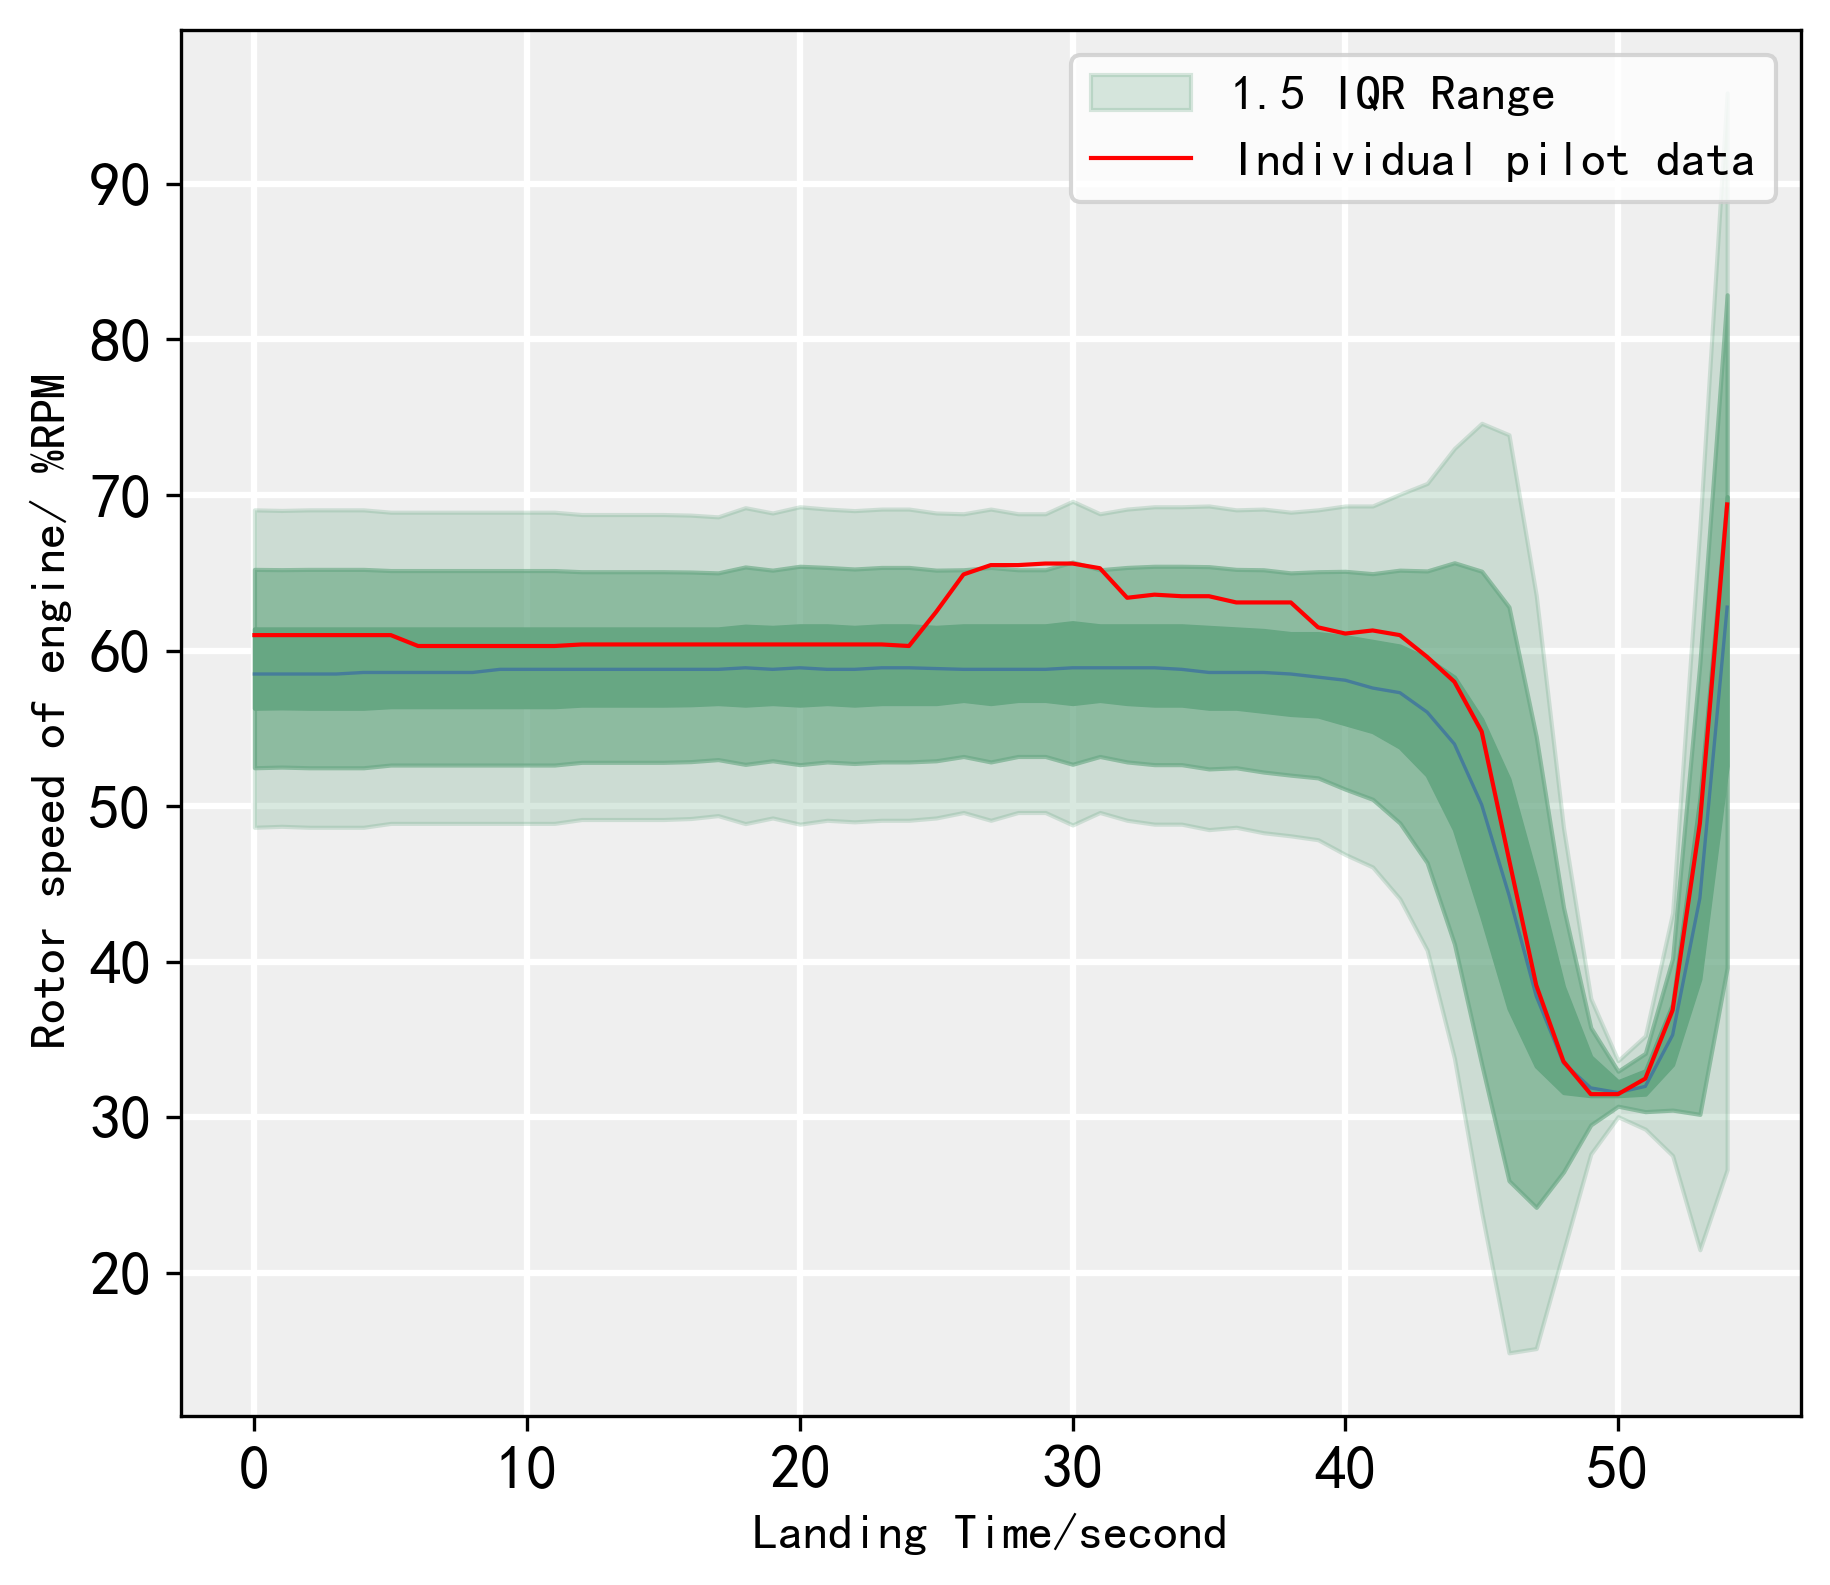

0
1
2
图形已保存为 save/pilot_653_VRTG.pdf
FPI分数:98.77723121274155


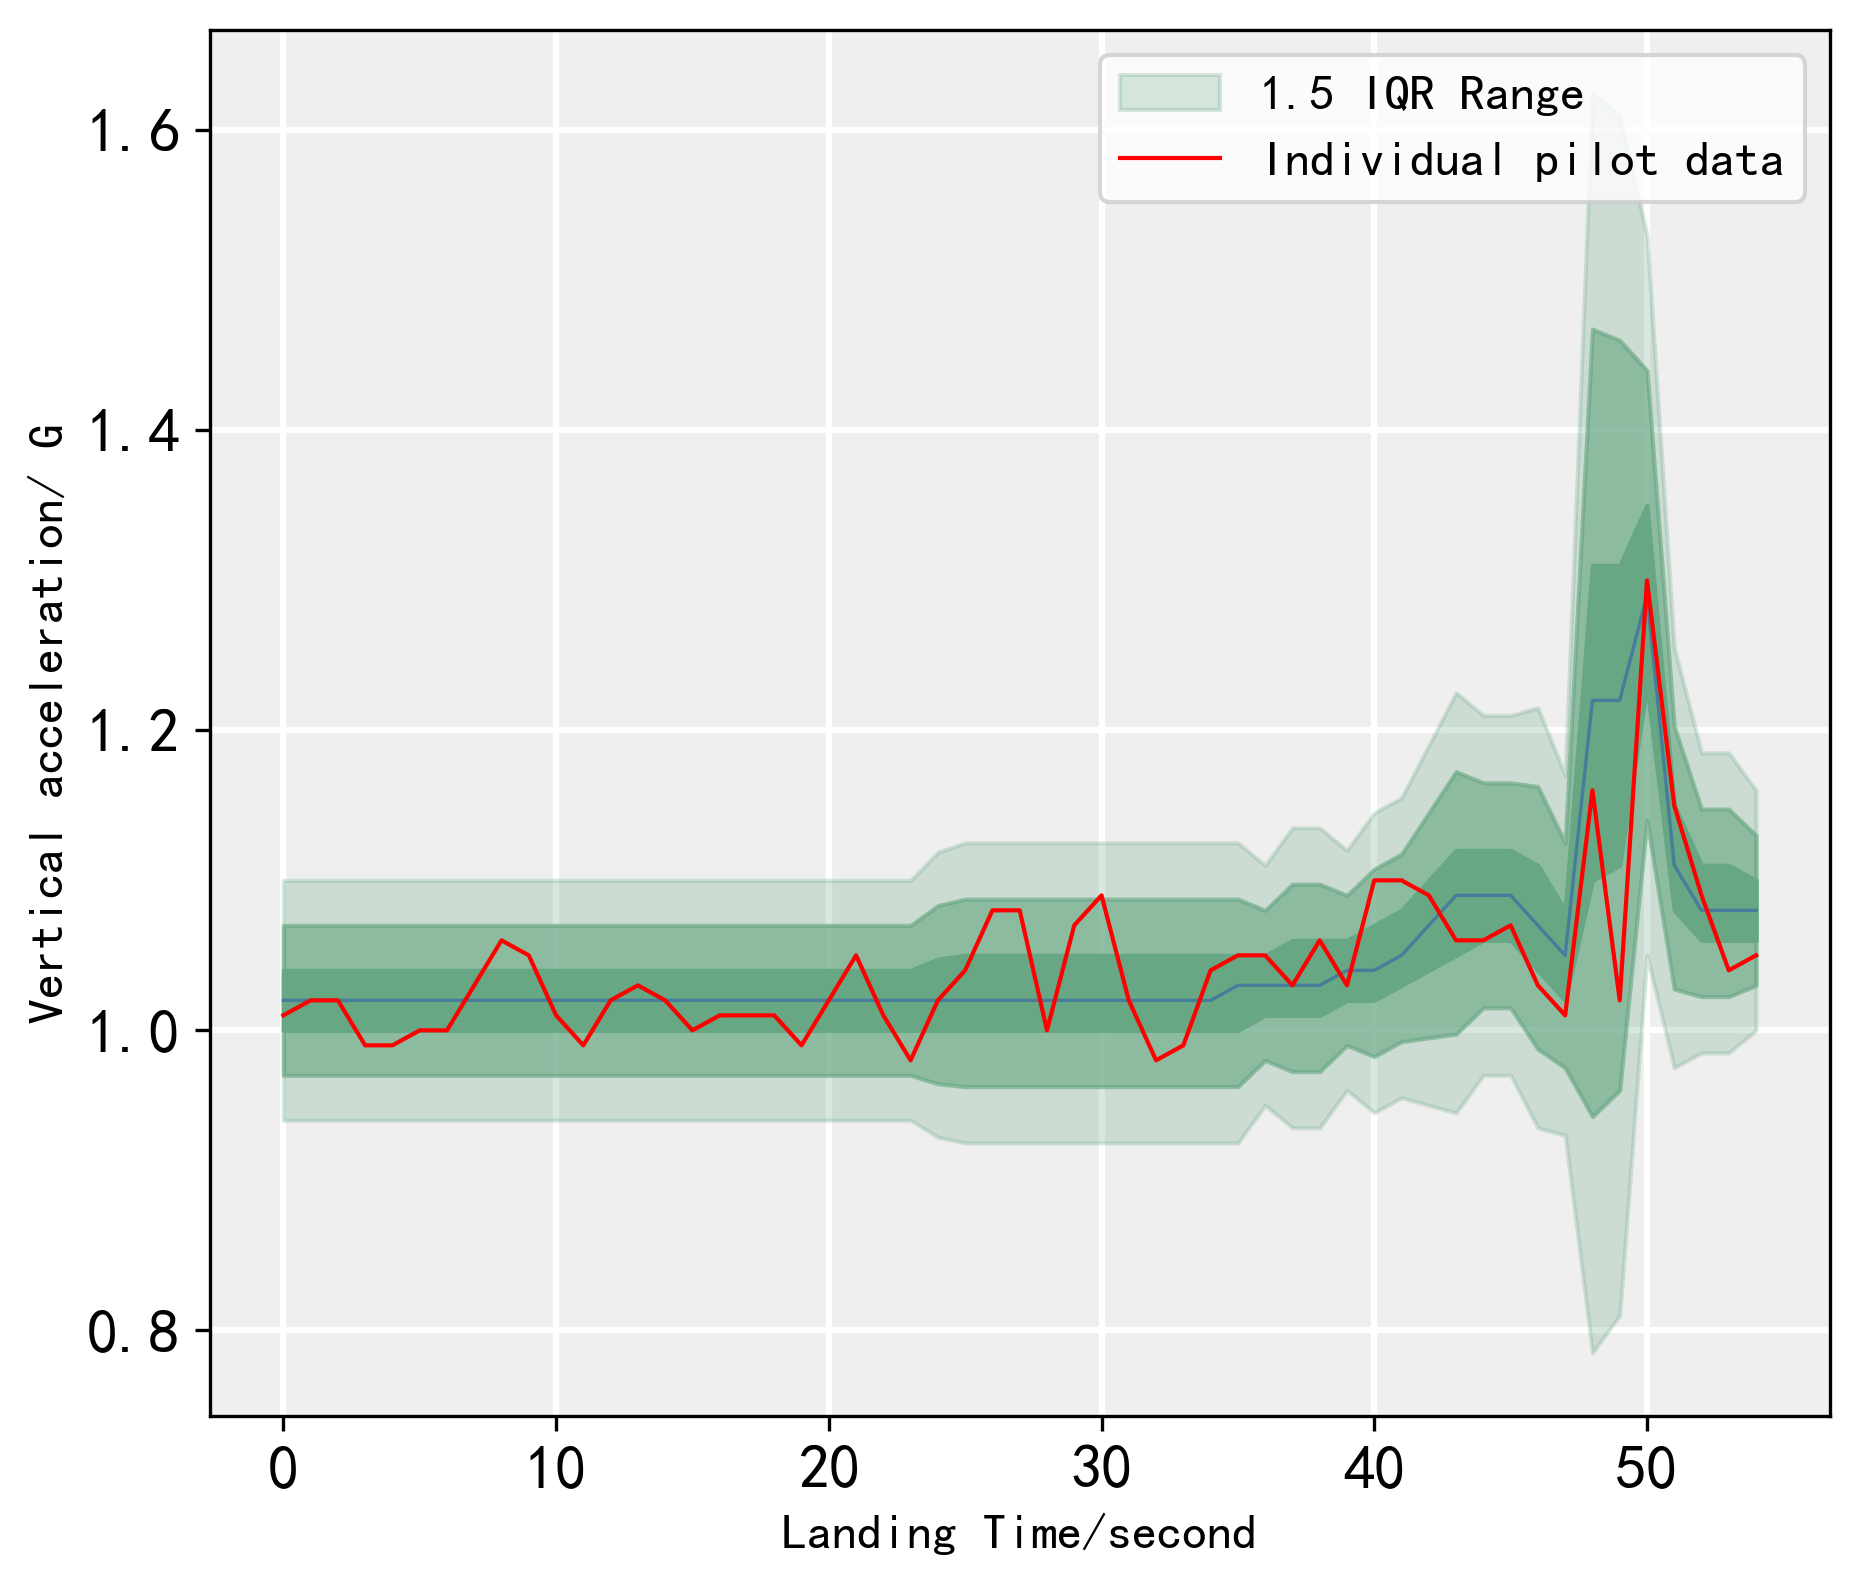

0
1
2
图形已保存为 save/pilot_653_ALT_RADIO.pdf
FPI分数:98.77723121274155


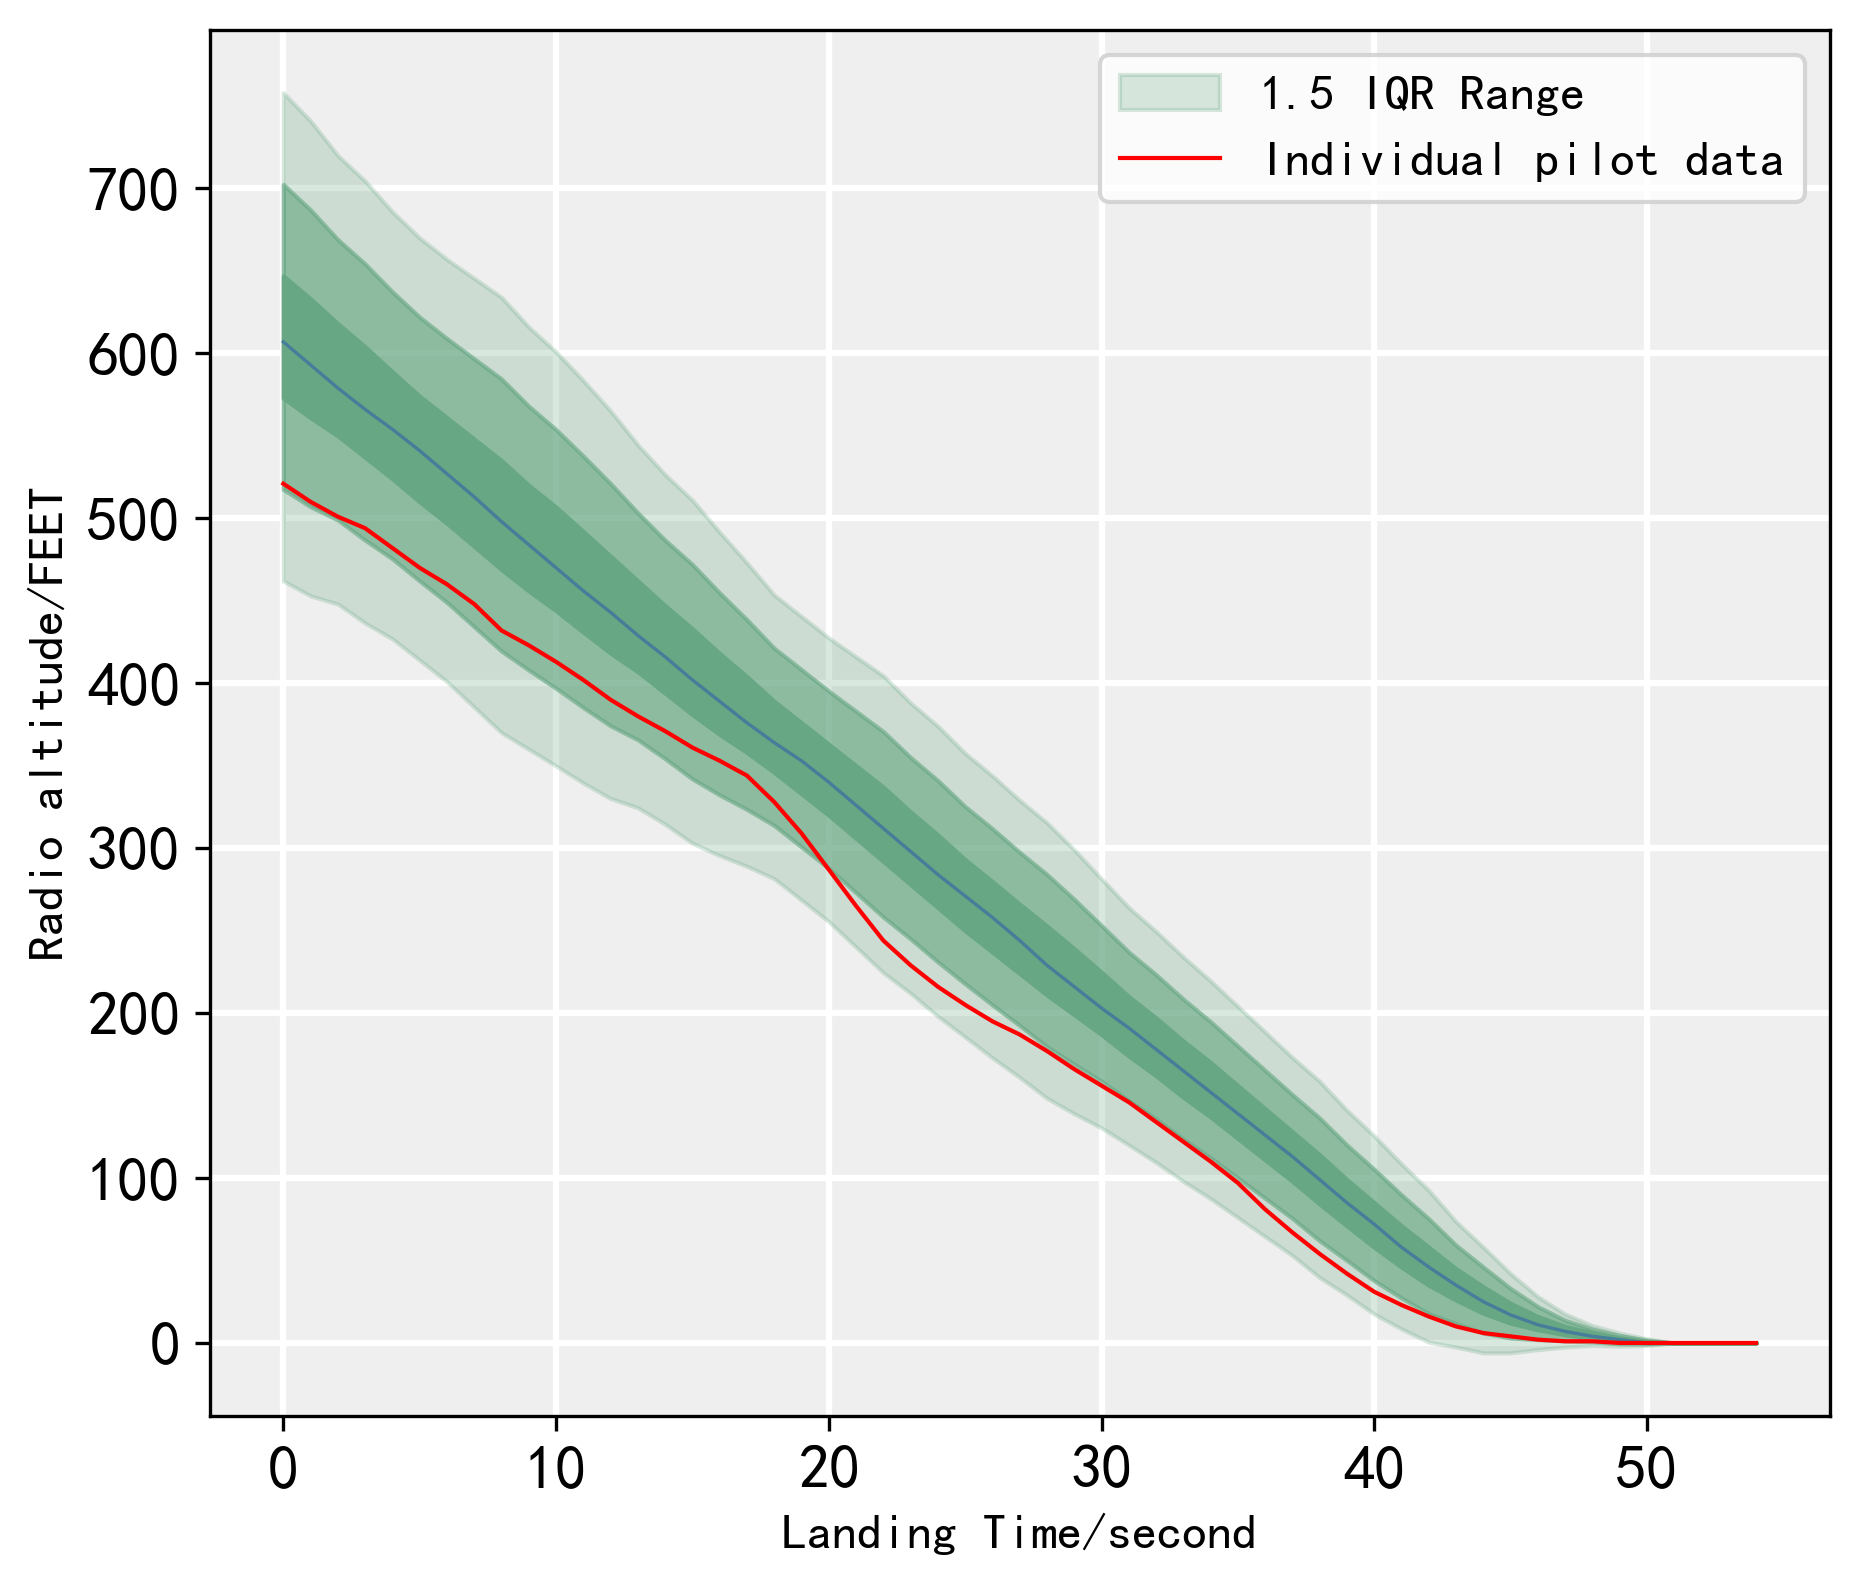

0
1
2
图形已保存为 save/pilot_653_DIST_TO_THR_CONV.pdf
FPI分数:98.77723121274155


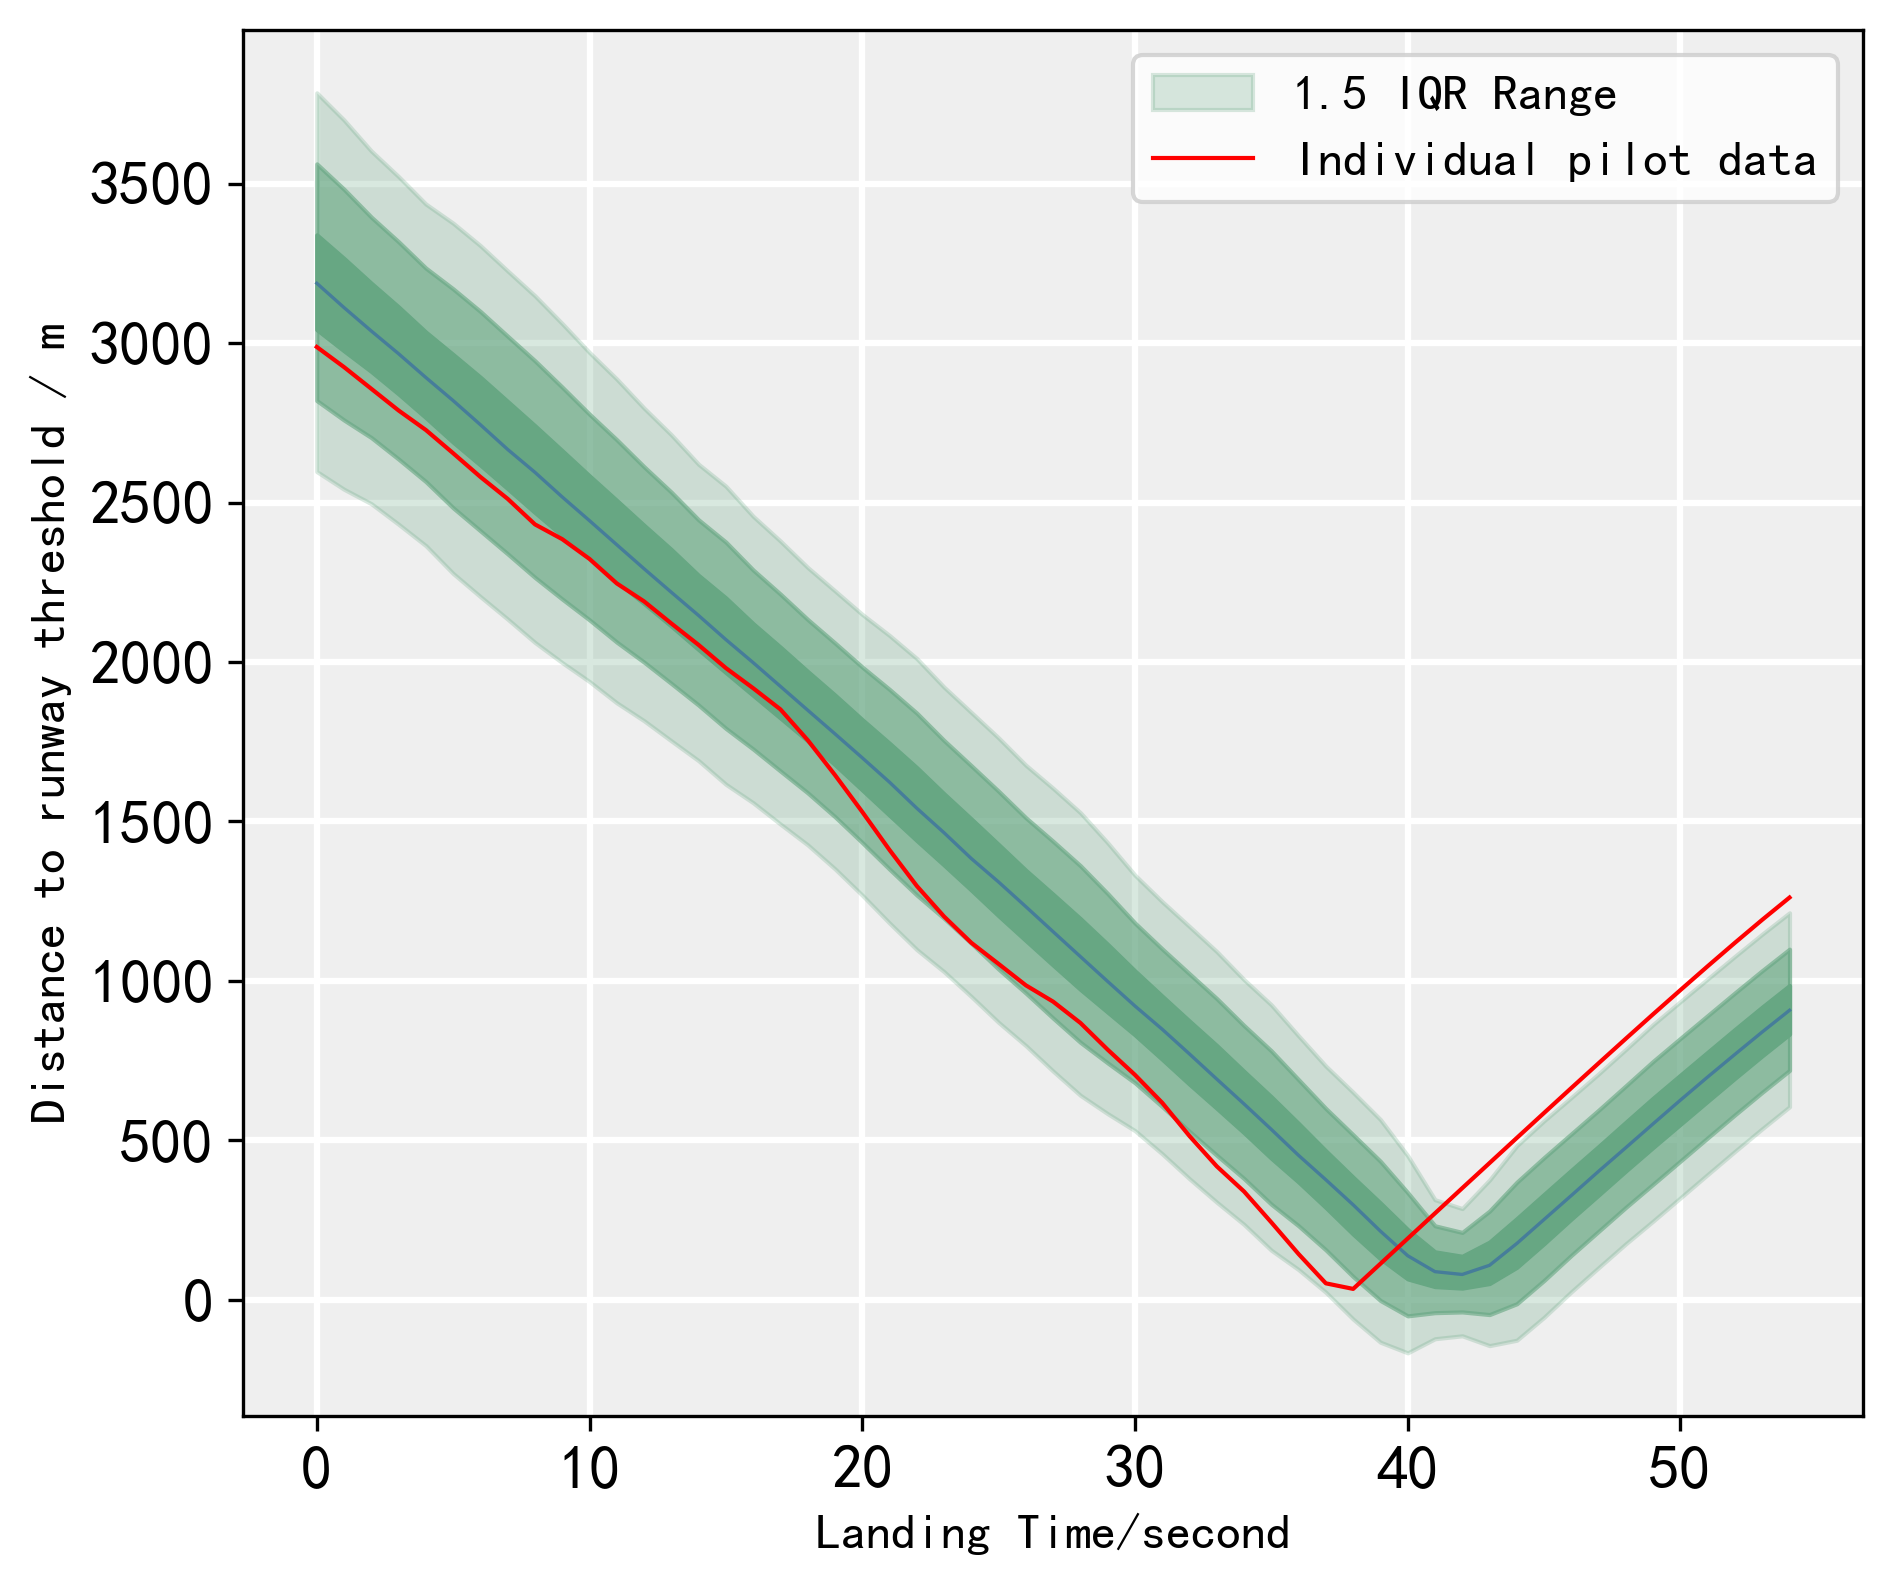

0
1
2
图形已保存为 save/pilot_653_IVV.pdf
FPI分数:98.77723121274155


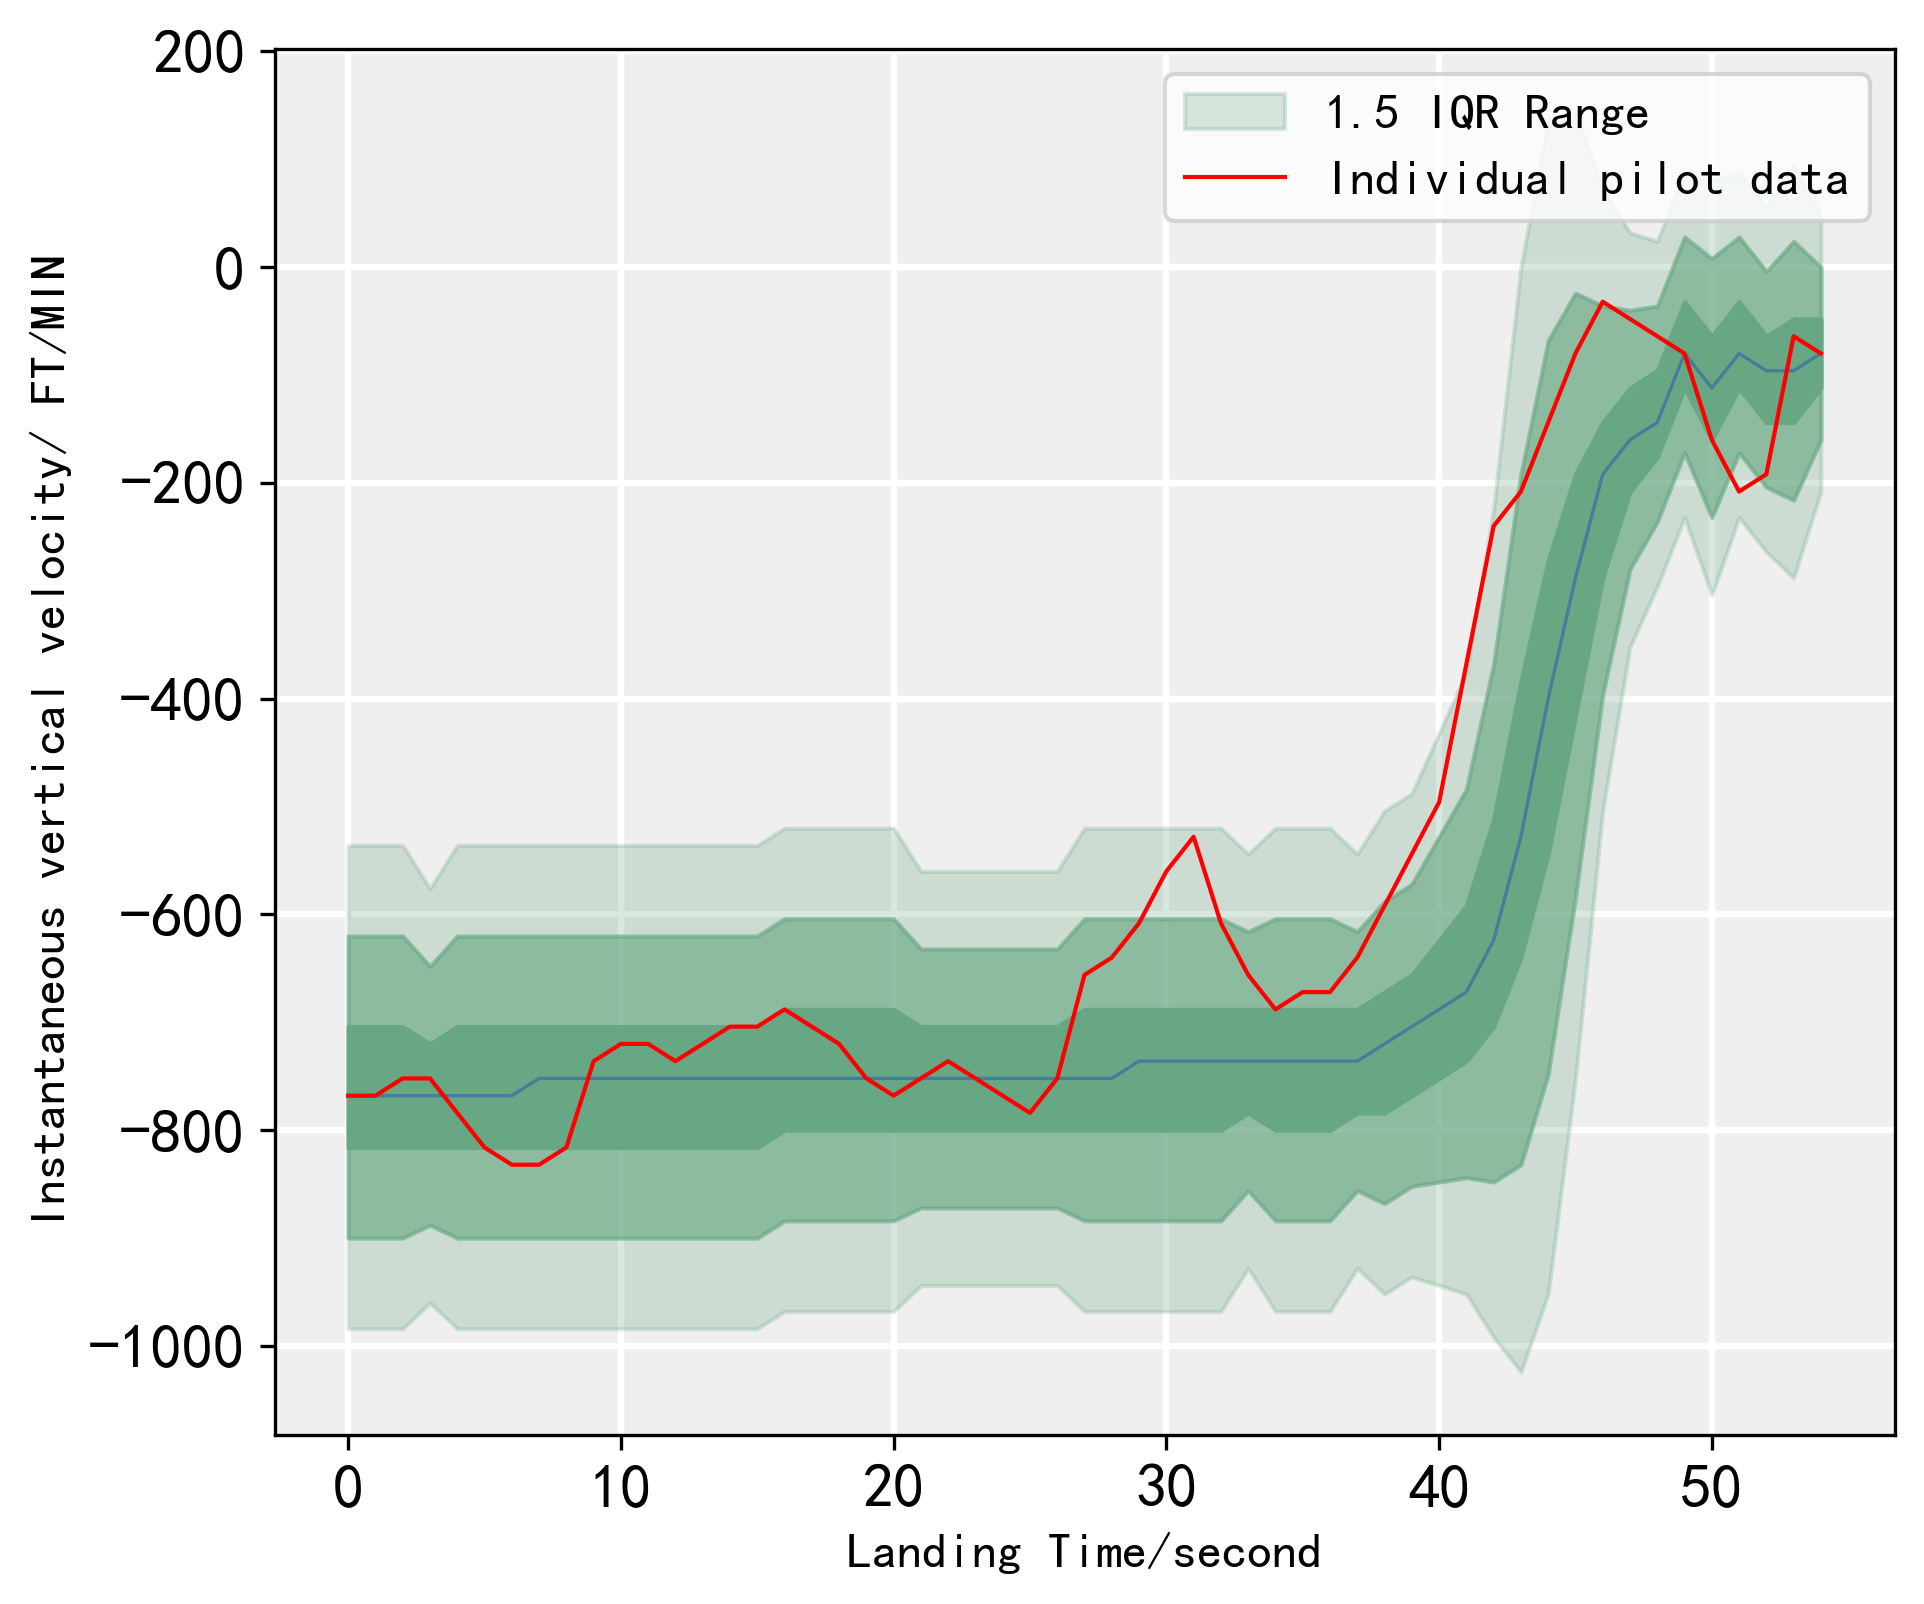

0
1
2
图形已保存为 save/pilot_653_LOC.pdf
FPI分数:98.77723121274155


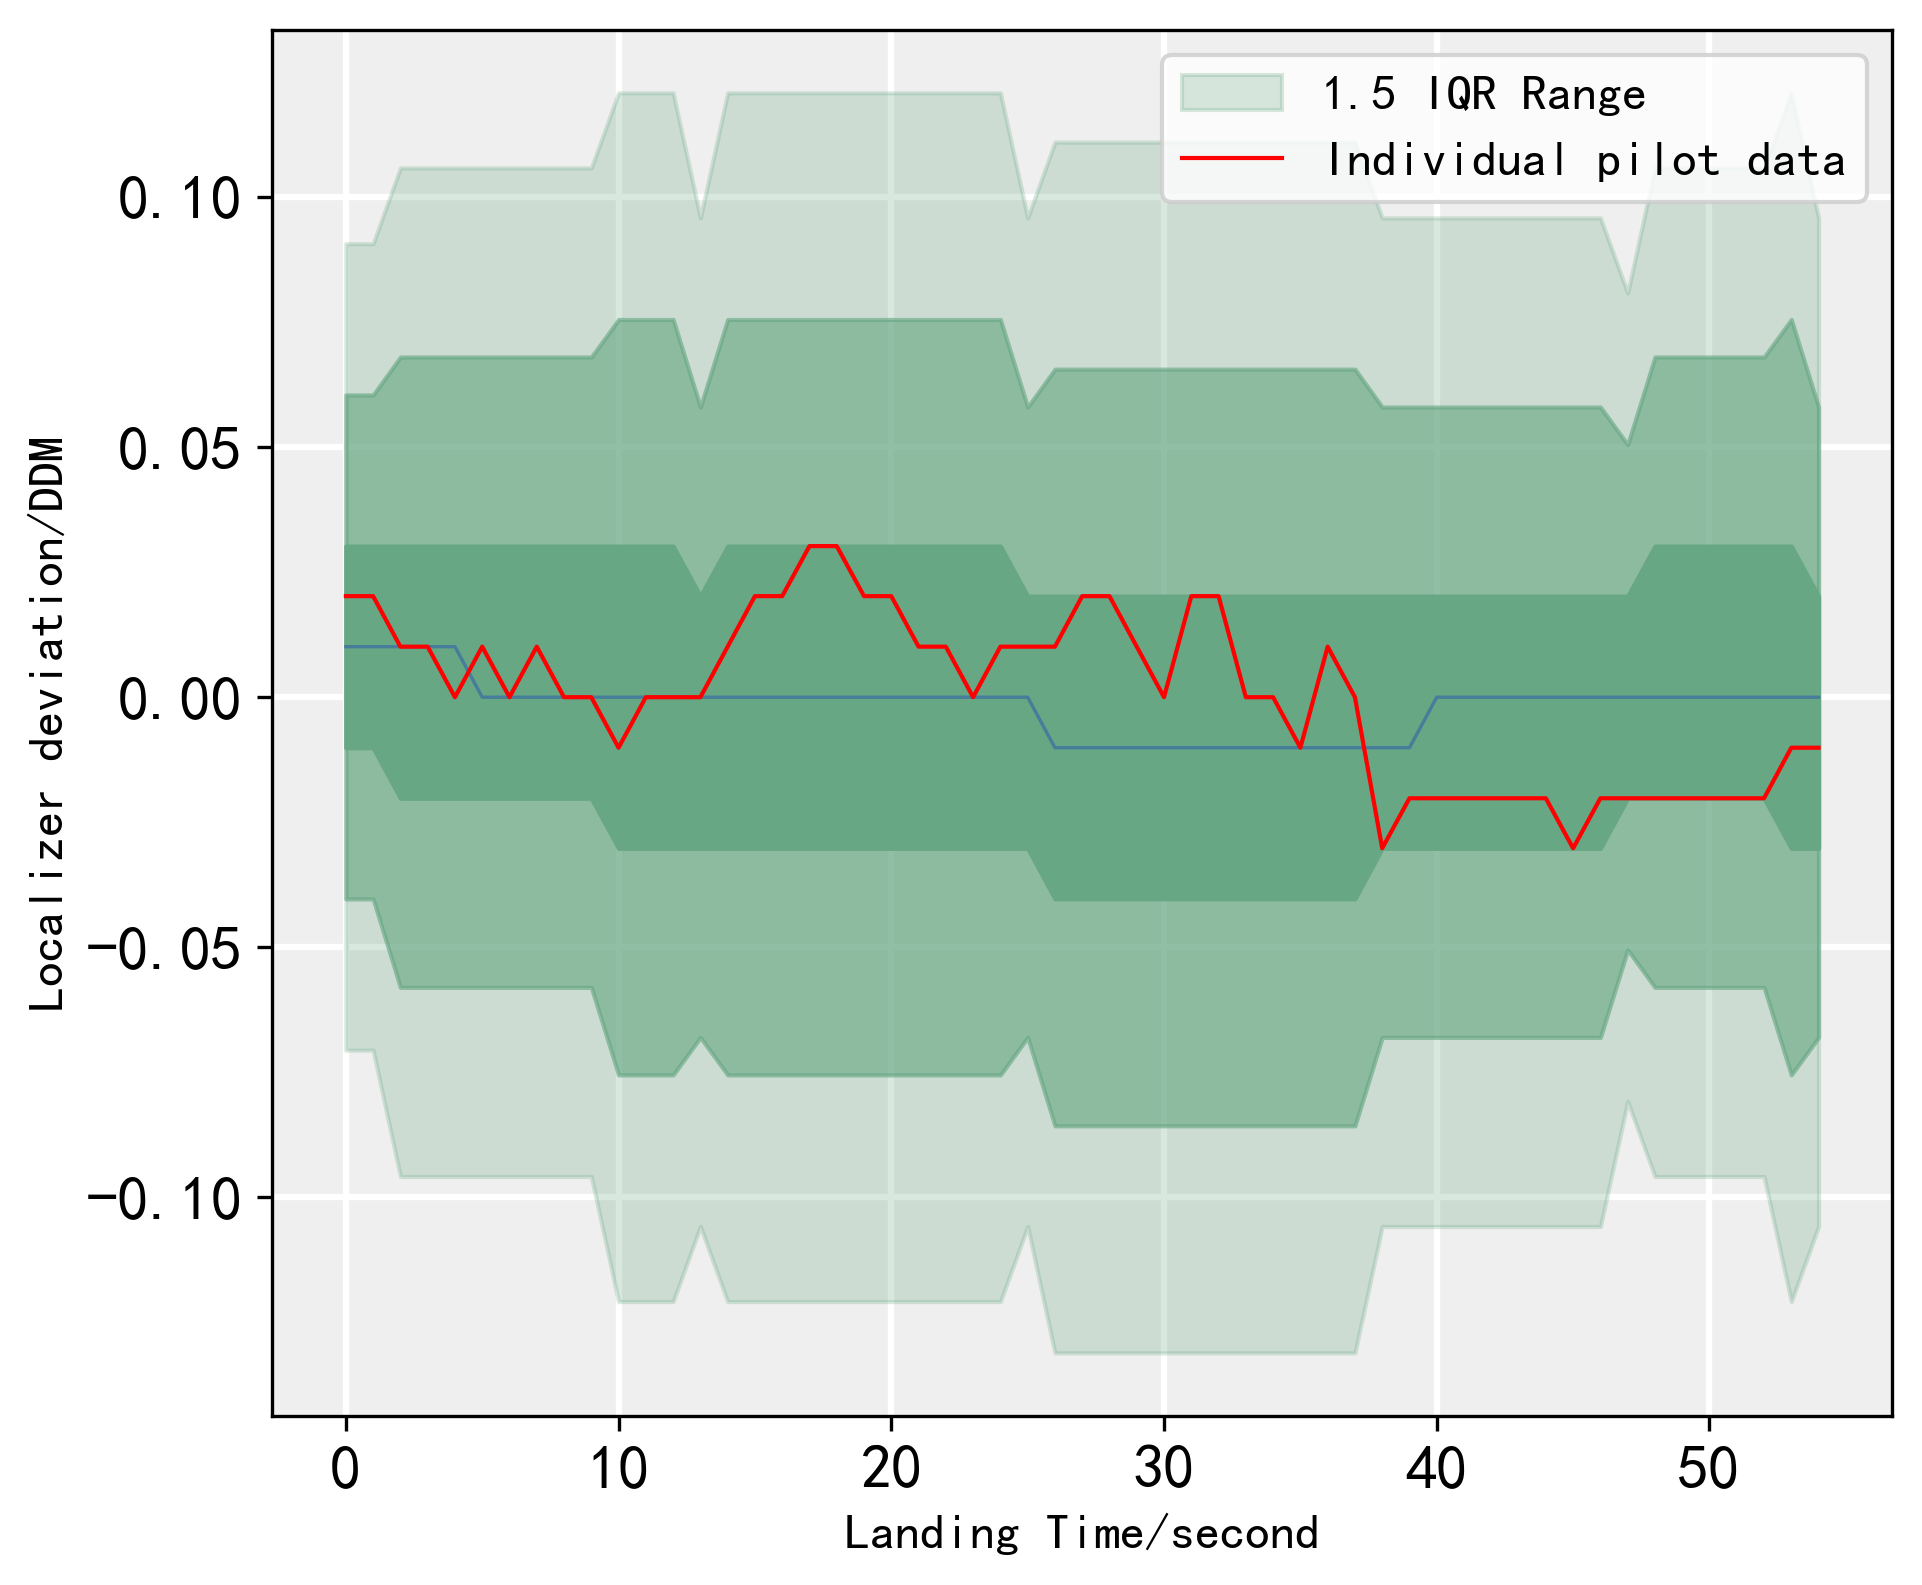

0
1
2
图形已保存为 save/pilot_653_PITCH.pdf
FPI分数:98.77723121274155


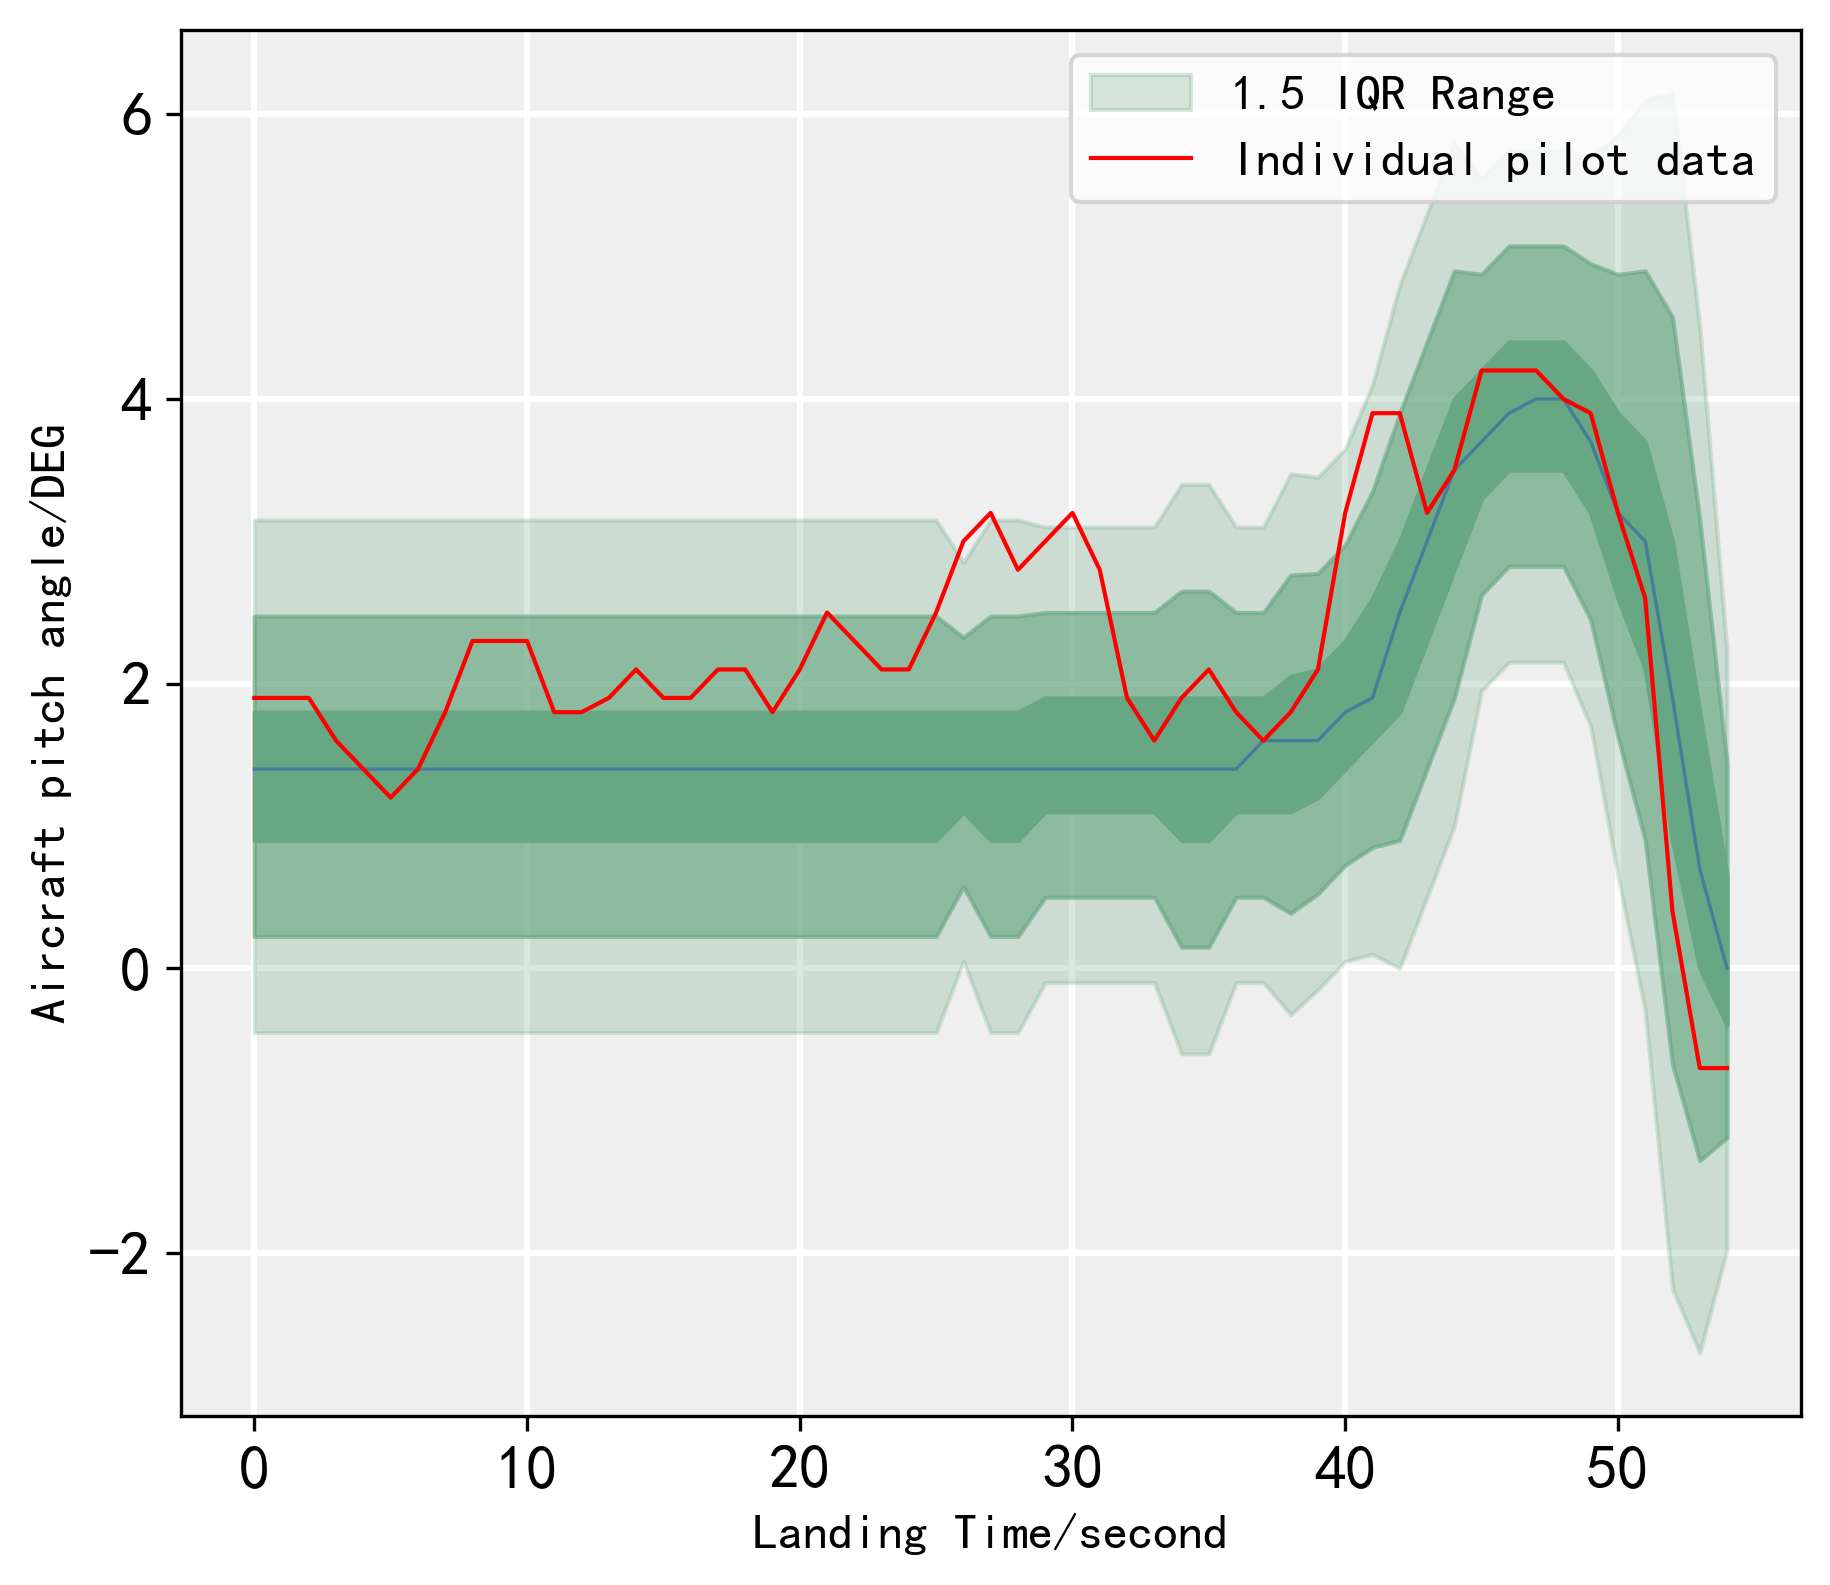

In [800]:
for i in range(7):
 iqr_pic(653,yname[i],ylabel[i],save=1)
